In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
"""
GRU Story Generation - TPU/GPU/CPU Auto-Detection Version
Automatically uses TPU (if available), then GPU, then CPU

FIXES:
- Fixes 'M1' NameError typo in train_epoch.
- Removes xmp.spawn from __main__ to prevent 'AttributeError' crash in notebooks.
  (This will run on a single TPU core, which is what the env supports).
- Keeps xm.rendezvous() for future multi-process use (it's safe).
"""

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import numpy as np
from tqdm import tqdm

# Set tokenizer parallelism to false
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ============================================================================
# Device Detection and Setup
# ============================================================================

def setup_device():
    """Detect and setup TPU, GPU, or CPU"""
    device_type = "cpu"
    device = torch.device("cpu")
    num_devices = 1
    use_tpu = False
    
    # Try TPU first
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm
        import torch_xla.runtime as xr
        
        # Check if TPU is actually available
        if xr.device_type() == 'TPU':
            device = xm.xla_device() # Gets the specific device for this process
            device_type = "tpu"
            num_devices = xr.world_size() # Gets total number of processes
            use_tpu = True
            print(f"✓ TPU detected! This is process {xr.global_ordinal()} of {num_devices}")
            print(f"  TPU device: {device}")
            return device, device_type, num_devices, use_tpu
        else:
            print(f"[{os.getpid()}] torch_xla found, but no TPU device. Falling back to GPU/CPU.")
            
    except ImportError:
        print(f"[{os.getpid()}] torch_xla not installed. Skipping TPU.")
    except Exception as e:
        print(f"[{os.getpid()}] TPU detection error: {e}. Falling back to GPU/CPU.")
    
    # Try GPU next
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_type = "cuda"
        num_devices = torch.cuda.device_count()
        print(f"✓ GPU detected! Using {num_devices} GPU(s)")
        return device, device_type, num_devices, use_tpu
    
    # Fallback to CPU
    print("⚠ No TPU or GPU detected. Using CPU")
    return device, device_type, num_devices, use_tpu

# ============================================================================
# Configuration
# ============================================================================

class Config:
    # Model architecture
    vocab_size = 4000
    embed_dim = 512
    hidden_dim = 1024
    num_layers = 3
    dropout = 0.3
    
    # Training
    batch_size = 256  # Per device batch size
    learning_rate = 0.001
    num_epochs = 100
    max_seq_len = 300
    grad_clip = 1.0
    grad_accum_steps = 1
    
    # Data sources
    use_tinystories = True
    tinystories_subset = 1000000
    custom_text_file = None
    # Generation
    gen_temperature = 0.8
    gen_max_len = 300
    # Optimization settings
    use_amp = True  # Will be disabled for TPU automatically
    num_workers = 4
    pin_memory = True
    # Multi-device settings
    use_data_parallel = True  # For multi-GPU
    # System (will be set automatically)
    device = None
    device_type = None
    num_devices = 1
    use_tpu = False # Set by setup_device
    save_path = 'gru_story_model.pt'

    # Paths for Kaggle environment
    train_csv_path = ""
    val_csv_path = ""
    csv_text_column = "text"
    csv_max_samples = 50000 

# ============================================================================
# Tokenizer
# ============================================================================

class BPETokenizer:
    def __init__(self, vocab_size=8000):
        self.vocab_size = vocab_size
        self.tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        self.tokenizer.pre_tokenizer = Whitespace()
        self.pad_token = "[PAD]"
        self.unk_token = "[UNK]"
        self.bos_token = "[BOS]"
        self.eos_token = "[EOS]"
    
    def train(self, texts):
        trainer = BpeTrainer(
            vocab_size=self.vocab_size, 
            special_tokens=[self.pad_token, self.unk_token, self.bos_token, self.eos_token]
        )
        self.tokenizer.train_from_iterator(texts, trainer)
        self.pad_id = self.tokenizer.token_to_id(self.pad_token)
        self.bos_id = self.tokenizer.token_to_id(self.bos_token)
        self.eos_id = self.tokenizer.token_to_id(self.eos_token)
    
    def encode(self, text):
        return self.tokenizer.encode(text).ids
    
    def decode(self, ids):
        return self.tokenizer.decode(ids)
    
    def save(self, path):
        self.tokenizer.save(path)
    
    def load(self, path):
        self.tokenizer = Tokenizer.from_file(path)
        self.pad_id = self.tokenizer.token_to_id(self.pad_token)
        self.bos_id = self.tokenizer.token_to_id(self.bos_token)
        self.eos_id = self.tokenizer.token_to_id(self.eos_token)

# ============================================================================
# Dataset
# ============================================================================

class StoryDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
        print(f"[{os.getpid()}] Pre-tokenizing dataset...")
        self.tokenized = []
        # Only show progress bar on one process
        is_master = True
        if "XLA_GLOBAL_ORDINAL" in os.environ:
            is_master = (int(os.environ["XLA_GLOBAL_ORDINAL"]) == 0)
            
        for text in tqdm(texts, desc="Tokenizing", disable=not is_master):
            tokens = [tokenizer.bos_id] + tokenizer.encode(text)
            tokens = tokens[:max_len-1] + [tokenizer.eos_id]
            self.tokenized.append(tokens)
    
    def __len__(self):
        return len(self.tokenized)
    
    def __getitem__(self, idx):
        tokens = self.tokenized[idx]
        x = tokens[:-1]
        y = tokens[1:]
        x_len = len(x)
        y_len = len(y)
        # Pad to max_len - 1 for x and y
        x_padded = x + [self.tokenizer.pad_id] * (self.max_len - 1 - x_len)
        y_padded = y + [self.tokenizer.pad_id] * (self.max_len - 1 - y_len)
        
        # Ensure they are the correct length (max_len - 1)
        x_padded = x_padded[:self.max_len-1]
        y_padded = y_padded[:self.max_len-1]
        
        return torch.tensor(x_padded, dtype=torch.long), torch.tensor(y_padded, dtype=torch.long)

# ============================================================================
# Model
# ============================================================================

class GRUStoryLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_dim = config.hidden_dim
        self.num_layers = config.num_layers
        self.embed = nn.Embedding(config.vocab_size, config.embed_dim, padding_idx=0)
        self.gru = nn.GRU(
            config.embed_dim, 
            config.hidden_dim, 
            config.num_layers,
            batch_first=True,
            dropout=config.dropout if config.num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(config.dropout)
        self.proj = nn.Linear(config.hidden_dim, config.vocab_size)
        # ✅ Weight tying
        # self.proj.weight = self.embed.weight
        self._init_weights()
    
    def _init_weights(self):
        nn.init.xavier_uniform_(self.embed.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)
    
    def forward(self, x, hidden=None):
        embedded = self.dropout(self.embed(x))
        output, hidden = self.gru(embedded, hidden)
        logits = self.proj(self.dropout(output))
        return logits, hidden

# ============================================================================
# Helper Functions
# ============================================================================

def load_texts(config):
    """Load texts from local CSV, TinyStories, and/or custom file"""
    train_texts, val_texts = [], []
    
    # Try loading from local CSV first (fastest!)
    if config.train_csv_path and config.val_csv_path:
        try:
            import pandas as pd
            print(f"  → Loading from local CSV files...")
            print(f"    Train: {config.train_csv_path}")
            print(f"    Val:   {config.val_csv_path}")
            
            # Load train CSV
            train_df = pd.read_csv(config.train_csv_path)
            if config.csv_max_samples:
                train_df = train_df.head(config.csv_max_samples)
            train_texts = train_df[config.csv_text_column].tolist()
            print(f"  ✓ Loaded {len(train_texts)} training texts from CSV")
            
            # Load validation CSV
            val_df = pd.read_csv(config.val_csv_path)
            if config.csv_max_samples:
                # Load a proportional amount of validation data
                val_subset = max(100, config.csv_max_samples // 10)
                val_df = val_df.head(val_subset)
            val_texts = val_df[config.csv_text_column].tolist()
            print(f"  ✓ Loaded {len(val_texts)} validation texts from CSV")
            
        except Exception as e:
            print(f"  ⚠ Could not load CSV files: {e}")
            print(f"  → Falling back to TinyStories download...")
            # Fall through to TinyStories loading
    
    # Fallback to downloading TinyStories if CSV loading failed or not configured
    if not train_texts and config.use_tinystories:
        print("  → Downloading TinyStories dataset (this may take 1-2 minutes)...")
        ds = load_dataset("roneneldan/TinyStories")
        print("  → Dataset downloaded! Processing...")
        train_ds = ds['train']
        val_ds = ds['validation']
        
        if config.tinystories_subset:
            print(f"  → Using subset: {config.tinystories_subset} training samples")
            train_ds = train_ds.select(range(min(config.tinystories_subset, len(train_ds))))
            val_ds = val_ds.select(range(min(config.tinystories_subset // 10, len(val_ds))))
        
        print(f"  → Extracting {len(train_ds)} training texts...")
        train_texts = [x['text'] for x in tqdm(train_ds, desc="  Loading train")]
        print(f"  → Extracting {len(val_ds)} validation texts...")
        val_texts = [x['text'] for x in tqdm(val_ds, desc="  Loading val")]
    
    # Add custom text file if provided
    if config.custom_text_file:
        print(f"  → Loading custom text file: {config.custom_text_file}")
        with open(config.custom_text_file, 'r', encoding='utf-8') as f:
            content = f.read()
        custom_texts = [s.strip() for s in content.split('\n\n') if s.strip()]
        split_idx = int(len(custom_texts) * 0.9)
        train_texts.extend(custom_texts[:split_idx])
        val_texts.extend(custom_texts[split_idx:])
        print(f"  ✓ Added {len(custom_texts)} texts from custom file")
    
    print(f"  ✓ Total: {len(train_texts)} training texts, {len(val_texts)} validation texts")
    return train_texts, val_texts

def generate(model, tokenizer, prompt, config):
    """Generate story continuation from prompt"""
    # Get base model if wrapped
    base_model = model.module if isinstance(model, nn.DataParallel) else model
    was_training = base_model.training
    base_model.eval()
    
    with torch.no_grad():
        tokens = [tokenizer.bos_id] + tokenizer.encode(prompt)
        for i in range(config.gen_max_len):
            # Move tensor to the correct device
            x = torch.tensor([tokens], device=config.device)
            
            # TPU doesn't support autocast, use it only for CUDA
            if config.device_type == "cuda" and config.use_amp:
                with autocast(device_type='cuda', enabled=True):
                    logits, _ = base_model(x)
            else:
                logits, _ = base_model(x)
                
            logits = logits[0, -1, :] / config.gen_temperature
            probs = torch.softmax(logits, dim=0)
            next_token = torch.multinomial(probs, 1).item()
            if next_token == tokenizer.eos_id:
                break
            tokens.append(next_token)
        generated = tokenizer.decode(tokens[1:])
        if len(tokens) >= config.gen_max_len + 1:
            generated += " [TRUNCATED]"
    
    if was_training:
        base_model.train()
    
    return generated

def train_epoch(model, loader, optimizer, criterion, scaler, config):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    # For TPU, we need to use the parallel loader
    if config.use_tpu:
        import torch_xla.core.xla_model as xm
        import torch_xla.distributed.parallel_loader as pl
        # Only wrap if it's not already a ParallelLoader
        if not isinstance(loader, pl.PerDeviceLoader):
            loader = pl.ParallelLoader(loader, [config.device]).per_device_loader(config.device)
    
    # Only show pbar on master process
    is_master = (config.use_tpu and xm.is_master_ordinal()) or (not config.use_tpu)
    pbar = tqdm(loader, desc="Training", disable=not is_master)
    
    for batch_idx, (x, y) in enumerate(pbar):
        # x, y are already on config.device if using TPU/ParallelLoader
        if not config.use_tpu:
            x, y = x.to(config.device, non_blocking=True), y.to(config.device, non_blocking=True)
        
        # Use autocast only for CUDA
        if config.device_type == "cuda" and config.use_amp:
            with autocast(device_type='cuda', enabled=True):
                logits, _ = model(x)
                loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
                loss = loss / config.grad_accum_steps
            scaler.scale(loss).backward()
        else:
            logits, _ = model(x)
            # *** FIX 2: Corrected -M1 to -1 ***
            loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
            loss = loss / config.grad_accum_steps
            loss.backward()
        
        if (batch_idx + 1) % config.grad_accum_steps == 0:
            if config.device_type == "cuda" and config.use_amp:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
                if config.use_tpu:
                    xm.optimizer_step(optimizer)
                    xm.mark_step() 
                else:
                    optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * config.grad_accum_steps
        if is_master:
            pbar.set_postfix({'loss': f'{loss.item() * config.grad_accum_steps:.4f}'})
    
    # For TPU, average loss across devices
    if config.use_tpu:
        total_loss = xm.mesh_reduce('train_loss_reduce', total_loss, np.mean)
        
    return total_loss / len(loader)

def validate(model, loader, criterion, config):
    model.eval()
    total_loss = 0
    
    # For TPU, we need to use the parallel loader
    if config.use_tpu:
        import torch_xla.core.xla_model as xm
        import torch_xla.distributed.parallel_loader as pl
        if not isinstance(loader, pl.PerDeviceLoader):
            loader = pl.ParallelLoader(loader, [config.device]).per_device_loader(config.device)
    
    # Only show pbar on master process
    is_master = (config.use_tpu and xm.is_master_ordinal()) or (not config.use_tpu)
    pbar = tqdm(loader, desc="Validating", disable=not is_master)
    
    with torch.no_grad():
        for x, y in pbar:
            if not config.use_tpu:
                x, y = x.to(config.device, non_blocking=True), y.to(config.device, non_blocking=True)
            
            # Use autocast only for CUDA
            if config.device_type == "cuda" and config.use_amp:
                with autocast(device_type='cuda', enabled=True):
                    logits, _ = model(x)
                    loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
            else:
                logits, _ = model(x)
                loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
            
            total_loss += loss.item()
    
    # For TPU, average loss across devices
    if config.use_tpu:
        total_loss = xm.mesh_reduce('val_loss_reduce', total_loss, np.mean)

    return total_loss / len(loader)

# ============================================================================
# Main Training Function
# ============================================================================

def train():
    """Main training function - auto-detects TPU/GPU/CPU"""
    
    config = Config()
    
    # Setup device (TPU/GPU/CPU)
    config.device, config.device_type, config.num_devices, config.use_tpu = setup_device()
    
    # Import xm here, only after setup_device
    if config.use_tpu:
        import torch_xla.core.xla_model as xm
        
    # Disable AMP for TPU (not supported) and CPU
    if config.device_type in ["tpu", "cpu"]:
        config.use_amp = False
    
    # Disable pin_memory for TPU
    if config.use_tpu:
        config.pin_memory = False
        
    # Only print from master process on TPU
    is_master = (config.use_tpu and xm.is_master_ordinal()) or (not config.use_tpu)
    
    if is_master:
        print(f"Device type: {config.device_type}")
        print(f"Number of devices: {config.num_devices}")
        print(f"Optimizations: AMP={config.use_amp}, PinMemory={config.pin_memory}")
        
        if config.num_devices > 1:
            print(f"Effective batch size: {config.batch_size} per device × {config.num_devices} = {config.batch_size * config.num_devices}")
        
        print("\nLoading texts...")
        
    train_texts, val_texts = load_texts(config)
    
    tokenizer = BPETokenizer(vocab_size=config.vocab_size)
    tokenizer_path = "tokenizer.json"
    
    if is_master:
        print("\nTraining BPE tokenizer...")
        tokenizer.train(train_texts)
        tokenizer.save(tokenizer_path)
        print(f"Tokenizer vocab size: {config.vocab_size}")
    
    # Barrier to ensure tokenizer is saved before other processes load it
    if config.use_tpu and config.num_devices > 1:
        # Use xm.rendezvous() for synchronization (only needed if num_devices > 1)
        xm.rendezvous('tokenizer_save_barrier')
        
    # All processes load the tokenizer
    if not is_master:
        tokenizer.load(tokenizer_path)
        
    train_ds = StoryDataset(train_texts, tokenizer, config.max_seq_len + 1) # +1 for x/y shift
    val_ds = StoryDataset(val_texts, tokenizer, config.max_seq_len + 1) # +1 for x/y shift
    
    # TPU requires special sampler
    if config.use_tpu and config.num_devices > 1:
        import torch_xla.runtime as xr
        
        world_size = xr.world_size()
        rank = xr.global_ordinal()
        
        train_sampler = torch.utils.data.distributed.DistributedSampler(
            train_ds,
            num_replicas=world_size,
            rank=rank,
            shuffle=True
        )
        val_sampler = torch.utils.data.distributed.DistributedSampler(
            val_ds,
            num_replicas=world_size,
            rank=rank,
            shuffle=False
        )
        shuffle = False
        sampler_train = train_sampler
        sampler_val = val_sampler
    else:
        # Standard single-process loader
        shuffle = True
        sampler_train = None
        sampler_val = None
    
    train_loader = DataLoader(
        train_ds, 
        batch_size=config.batch_size, 
        shuffle=shuffle,
        num_workers=config.num_workers if not config.use_tpu else 0,
        pin_memory=config.pin_memory,
        persistent_workers=(config.num_workers > 0 and not config.use_tpu),
        sampler=sampler_train,
        drop_last=True # Good for distributed training
    )
    val_loader = DataLoader(
        val_ds, 
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers if not config.use_tpu else 0,
        pin_memory=config.pin_memory,
        persistent_workers=(config.num_workers > 0 and not config.use_tpu),
        sampler=sampler_val,
        drop_last=True # Good for distributed training
    )
    
    model = GRUStoryLM(config).to(config.device)
    
    # Wrap model for multi-device (GPU only, TPU handles this differently)
    if config.num_devices > 1 and config.device_type == "cuda" and config.use_data_parallel:
        model = nn.DataParallel(model)
        if is_master:
            print(f"Model wrapped in DataParallel with {config.num_devices} GPUs")
    
    if is_master:
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model params: {total_params:,}")
    
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=0.01)
    
    scaler = GradScaler(enabled=config.use_amp)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    
    best_val_loss = float('inf')
    
    if is_master:
        print("\n" + "="*60)
        print("Starting training...")
        print("="*60)
    
    for epoch in range(config.num_epochs):
        if is_master:
            print(f"\n{'='*60}\nEpoch {epoch+1}/{config.num_epochs} (LR: {scheduler.get_last_lr()[0]:.6f})\n{'='*60}")
        
        if config.use_tpu and config.num_devices > 1:
            train_sampler.set_epoch(epoch)
        
        train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler, config)
        val_loss = validate(model, val_loader, criterion, config)
        
        scheduler.step()
        
        if is_master:
            print(f"Train Loss: {train_loss:.4f} (PPL: {np.exp(train_loss):.2f})")
            print(f"Val Loss:   {val_loss:.4f} (PPL: {np.exp(val_loss):.2f})")
            
            sample = generate(model, tokenizer, "Once upon a time", config)
            print(f"\nSample:\n{sample}\n")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                
                # Save the base model (unwrap if needed)
                model_to_save = model.module if isinstance(model, nn.DataParallel) else model
                
                # For TPU, use xm.save
                if config.use_tpu:
                    xm.save({
                        'model_state': model_to_save.state_dict(),
                        'config': config.__dict__,
                        'tokenizer_path': tokenizer_path,
                        'epoch': epoch,
                        'best_val_loss': best_val_loss
                    }, config.save_path)
                else:
                    torch.save({
                        'model_state': model_to_save.state_dict(),
                        'config': config.__dict__,
                        'tokenizer_path': tokenizer_path,
                        'epoch': epoch,
                        'best_val_loss': best_val_loss
                    }, config.save_path)
                print("✓ Saved best model")
        
        # Barrier to ensure all processes finish epoch before starting next
        if config.use_tpu and config.num_devices > 1:
            # Use xm.rendezvous() for synchronization
            xm.rendezvous('epoch_end_barrier')

    if is_master:
        print("\n" + "="*60)
        print("Training complete! Generating final samples...")
        print("="*60)
        
        for prompt in ["Once upon a time", "There was a", "In a magical"]:
            story = generate(model, tokenizer, prompt, config)
            print(f"\n[{prompt}]\n{story}\n")

# ============================================================================
# Entry Point
# ============================================================================

def _mp_fn(index):
    """Multi-process function for TPU"""
    train()

# if __name__ == "__main__":
#     # *** FIX 1 ***
#     # Removed xmp.spawn logic. In a notebook, this is the most robust
#     # way to run. setup_device() will correctly find the 1 core
#     # allocated to this process and run on it.
#     print("Starting training process...")
#     train()

In [ ]:
# Run this FIRST in a separate cell to diagnose
def check_accelerators():
    """Diagnostic function to check what accelerators are available"""
    print("=" * 60)
    print("ACCELERATOR DIAGNOSTICS")
    print("=" * 60)
    
    # Check TPU
    print("\n1. Checking TPU...")
    try:
        import torch_xla
        print("   ✓ torch_xla is installed")
        
        import torch_xla.core.xla_model as xm
        print("   ✓ xla_model imported")
        
        try:
            device = xm.xla_device()
            print(f"   ✓ TPU device accessible: {device}")
            
            devices = xm.get_xla_supported_devices()
            print(f"   ✓ Available devices: {devices}")
            print(f"   ✓ Number of devices: {len(devices)}")
            
            # Check world size
            if hasattr(xm, 'xla_world_size'):
                ws = xm.xla_world_size()
                print(f"   ✓ World size (xla_world_size): {ws}")
            else:
                print("   ⚠ xla_world_size not available")
                
        except Exception as e:
            print(f"   ✗ TPU device error: {e}")
            
    except ImportError as e:
        print(f"   ✗ torch_xla not installed: {e}")
    
    # Check GPU
    print("\n2. Checking GPU...")
    try:
        import torch
        if torch.cuda.is_available():
            print(f"   ✓ CUDA available")
            print(f"   ✓ GPU count: {torch.cuda.device_count()}")
            for i in range(torch.cuda.device_count()):
                print(f"   ✓ GPU {i}: {torch.cuda.get_device_name(i)}")
        else:
            print("   ✗ No CUDA GPUs detected")
    except Exception as e:
        print(f"   ✗ GPU check error: {e}")
    
    # Check CPU
    print("\n3. CPU (always available)")
    print(f"   ✓ PyTorch version: {torch.__version__}")
    
    print("\n" + "=" * 60)

# Run the diagnostic
check_accelerators()

In [23]:
"""
GRU Story Generation - Inference/Testing Script
Load a saved model checkpoint and generate stories interactively
"""

import torch
import torch.nn as nn
from tokenizers import Tokenizer

# ============================================================================
# Inference Class
# ============================================================================

class StoryGenerator:
    def __init__(self, model_path='gru_story_model.pt', device=None):
        """
        Load a trained GRU Story model for inference
        
        Args:
            model_path: Path to the saved .pt checkpoint
            device: Device to run on ('cuda', 'cpu', or None for auto-detect)
        """
        # Auto-detect device if not specified
        if device is None:
            if torch.cuda.is_available():
                device = 'cuda'
                print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
            else:
                device = 'cpu'
                print("✓ Using CPU")
        
        self.device = torch.device(device)
        
        # Load checkpoint
        print(f"Loading model from {model_path}...")
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Extract config (handle different config storage formats)
        if 'config' in checkpoint:
            config = checkpoint['config']
            # Check if config is a dict or Config object
            if isinstance(config, dict):
                self.vocab_size = config.get('vocab_size', 4000)
                self.embed_dim = config.get('embed_dim', 512)
                self.hidden_dim = config.get('hidden_dim', 1024)
                self.num_layers = config.get('num_layers', 3)
                self.dropout = config.get('dropout', 0.3)
            else:
                # Config object with attributes
                self.vocab_size = getattr(config, 'vocab_size', 4000)
                self.embed_dim = getattr(config, 'embed_dim', 512)
                self.hidden_dim = getattr(config, 'hidden_dim', 1024)
                self.num_layers = getattr(config, 'num_layers', 3)
                self.dropout = getattr(config, 'dropout', 0.3)
        else:
            # Fallback: infer from model state dict
            print("⚠ Config not found in checkpoint, inferring from model state...")
            state_dict = checkpoint['model_state']
            self.vocab_size = state_dict['embed.weight'].shape[0]
            self.embed_dim = state_dict['embed.weight'].shape[1]
            self.hidden_dim = state_dict['gru.weight_hh_l0'].shape[1]
            self.num_layers = sum(1 for k in state_dict.keys() if 'gru.weight_hh_l' in k)
            self.dropout = 0.3  # default
        
        # Load tokenizer
        import os
        tokenizer_path = checkpoint.get('tokenizer_path', 'tokenizer.json')
        
        # If tokenizer_path is just filename, look in same dir as model
        if not os.path.exists(tokenizer_path):
            model_dir = os.path.dirname(model_path)
            tokenizer_path = os.path.join(model_dir, 'tokenizer.json')
            
        # If still not found, try just the filename in current dir
        if not os.path.exists(tokenizer_path):
            tokenizer_path = 'tokenizer.json'
            
        print(f"Loading tokenizer from {tokenizer_path}...")
        self.tokenizer = Tokenizer.from_file(tokenizer_path)
        self.pad_id = self.tokenizer.token_to_id("[PAD]")
        self.bos_id = self.tokenizer.token_to_id("[BOS]")
        self.eos_id = self.tokenizer.token_to_id("[EOS]")
        
        # Initialize model
        self.model = GRUStoryLM(
            self.vocab_size,
            self.embed_dim,
            self.hidden_dim,
            self.num_layers,
            self.dropout
        ).to(self.device)
        
        # Load model weights
        self.model.load_state_dict(checkpoint['model_state'])
        self.model.eval()
        
        # Training info
        epoch = checkpoint.get('epoch', 'unknown')
        val_loss = checkpoint.get('best_val_loss', 'unknown')
        print(f"✓ Model loaded successfully!")
        print(f"  Trained for {epoch} epochs, Best val loss: {val_loss}")
        print(f"  Vocab size: {self.vocab_size}, Hidden dim: {self.hidden_dim}")
        print()
    
    def _post_process(self, text):
        """
        Clean up common tokenization artifacts
        """
        import re
        
        # Fix specific common split words FIRST (before general patterns)
        specific_fixes = {
            'D av id': 'David',
            'Dav id': 'David',
            'S al ly': 'Sally',
            'Sal ly': 'Sally',
            'f ought': 'fought',
            'val our': 'valour',
            'bal anc ed': 'balanced',
            'present s': 'presents',
            'friend s': 'friends',
            't om orrow': 'tomorrow',
            't od ay': 'today',
            'y est erday': 'yesterday',
        }
        for wrong, right in specific_fixes.items():
            text = text.replace(wrong, right)
        
        # Fix split capitalized words (only single letter splits: D avid -> David)
        # But NOT regular words (to avoid merging "to explore" -> "toexplore")
        text = re.sub(r'\b([A-Z])\s+([a-z]{2,})\b', r'\1\2', text)
        
        # Fix contractions (Ican ' t -> I can't, Idon ' t -> I don't)
        text = re.sub(r'I\s*can\s*\'\s*t', "I can't", text)
        text = re.sub(r'I\s*don\s*\'\s*t', "I don't", text)
        text = re.sub(r'I\s*will', "I will", text)
        text = re.sub(r'I\s*\'?\s*m', "I'm", text)
        text = re.sub(r'([a-z]+)\s*n\s*\'\s*t\b', r"\1n't", text)
        text = re.sub(r'([a-z]+)\s*\'\s*s\b', r"\1's", text)
        text = re.sub(r'([a-z]+)\s*\'\s*re\b', r"\1're", text)
        text = re.sub(r'([a-z]+)\s*\'\s*ll\b', r"\1'll", text)
        text = re.sub(r'([a-z]+)\s*\'\s*ve\b', r"\1've", text)
        
        # Fix "Ican" -> "I can", "Iwill" -> "I will" (no spaces)
        text = re.sub(r'\bI([a-z])', r'I \1', text)
        
        # Fix multiple spaces
        text = re.sub(r' +', ' ', text)
        
        # Fix space before punctuation
        text = re.sub(r'\s+([.,!?;:])', r'\1', text)
        
        # Fix quotes with spaces (She said , " -> She said, ")
        text = re.sub(r'\s*,\s*"', ',"', text)
        text = re.sub(r'\s*"\s*([A-Z])', r'" \1', text)  # Space after opening quote before capital
        text = re.sub(r'([.!?])\s*"', r'\1"', text)  # No space before closing quote after punctuation
        
        # Fix space after opening quotes/parentheses
        text = re.sub(r'([("' + "'" + r'])\s+', r'\1', text)
        
        # Fix space before closing quotes/parentheses
        text = re.sub(r'\s+([)"' + "'" + r'])', r'\1', text)
        
        # Fix common split words that remain
        common_fixes = {
            'f ought': 'fought',
            'val our': 'valour',
            'bal anc ed': 'balanced',
            'present s': 'presents',
            'friend s': 'friends',
            'n ies': 'nies',  # Part of words
        }
        for wrong, right in common_fixes.items():
            text = text.replace(wrong, right)
        
        # Capitalize after sentence endings
        def capitalize_sentences(match):
            return match.group(1) + match.group(2).upper()
        text = re.sub(r'([.!?]\s+)([a-z])', capitalize_sentences, text)
        
        # Capitalize after quotes at start of sentence
        text = re.sub(r'(^|[.!?]\s+)"([a-z])', lambda m: m.group(1) + '"' + m.group(2).upper(), text)
        
        # Ensure first character is capitalized
        if text:
            text = text[0].upper() + text[1:]
        
        return text.strip()
    
    def generate(self, prompt, max_len=300, temperature=0.8, top_k=50, top_p=0.9, post_process=True):
        """
        Generate text continuation from a prompt
        
        Args:
            prompt: Starting text
            max_len: Maximum number of tokens to generate
            temperature: Sampling temperature (higher = more random)
            top_k: Keep only top k tokens for sampling (0 = disabled)
            top_p: Nucleus sampling threshold (1.0 = disabled)
            post_process: Apply post-processing to fix tokenization artifacts
        
        Returns:
            Generated text string
        """
        self.model.eval()
        
        with torch.no_grad():
            # Encode prompt
            tokens = [self.bos_id] + self.tokenizer.encode(prompt).ids
            
            # Generate tokens
            for _ in range(max_len):
                x = torch.tensor([tokens], device=self.device)
                logits, _ = self.model(x)
                
                # Get logits for last token
                logits = logits[0, -1, :] / temperature
                
                # Apply top-k filtering
                if top_k > 0:
                    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                    logits[indices_to_remove] = float('-inf')
                
                # Apply top-p (nucleus) filtering
                if top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                    cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                    
                    # Remove tokens with cumulative probability above the threshold
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0
                    
                    indices_to_remove = sorted_indices[sorted_indices_to_remove]
                    logits[indices_to_remove] = float('-inf')
                
                # Sample next token
                probs = torch.softmax(logits, dim=0)
                next_token = torch.multinomial(probs, 1).item()
                
                # Stop if EOS token
                if next_token == self.eos_id:
                    break
                
                tokens.append(next_token)
            
            # Decode tokens (skip BOS token)
            generated = self.tokenizer.decode(tokens[1:])
            
            # Apply post-processing if enabled
            if post_process:
                generated = self._post_process(generated)
            
        return generated
    
    def interactive(self):
        """Interactive generation mode"""
        print("="*60)
        print("Interactive Story Generation Mode")
        print("="*60)
        print("Commands:")
        print("  - Type a prompt to generate a story")
        print("  - 'quit' or 'exit' to exit")
        print("  - 'temp X' to set temperature (e.g., 'temp 0.7')")
        print("  - 'len X' to set max length (e.g., 'len 200')")
        print("="*60)
        print()
        
        temperature = 0.8
        max_len = 300
        
        while True:
            try:
                user_input = input("\n📝 Prompt: ").strip()
                
                if not user_input:
                    continue
                
                # Check for exit commands
                if user_input.lower() in ['quit', 'exit', 'q']:
                    print("Goodbye!")
                    break
                
                # Check for temperature command
                if user_input.lower().startswith('temp '):
                    try:
                        temperature = float(user_input.split()[1])
                        print(f"✓ Temperature set to {temperature}")
                        continue
                    except:
                        print("❌ Invalid temperature. Use: temp 0.8")
                        continue
                
                # Check for length command
                if user_input.lower().startswith('len '):
                    try:
                        max_len = int(user_input.split()[1])
                        print(f"✓ Max length set to {max_len}")
                        continue
                    except:
                        print("❌ Invalid length. Use: len 300")
                        continue
                
                # Generate story
                print("\n🎭 Generating...\n")
                story = self.generate(user_input, max_len=max_len, temperature=temperature)
                print(story)
                print("\n" + "-"*60)
                
            except KeyboardInterrupt:
                print("\n\nGoodbye!")
                break
            except Exception as e:
                print(f"❌ Error: {e}")

# ============================================================================
# Usage Examples
# ============================================================================

if __name__ == "__main__":
    # Load the model
    generator = StoryGenerator('/kaggle/input/story-gru-lm/pytorch/default/1/gru_story_model.pt')
    
    # Option 1: Generate a single story
    print("="*60)
    print("Example Generations")
    print("="*60)
    
    prompts = [
        "Once upon a time",
        "There was a little girl",
        "In a magical forest"
    ]
    
    for prompt in prompts:
        print(f"\n📝 Prompt: {prompt}")
        print("-"*60)
        story = generator.generate(prompt, max_len=800, temperature=1.5)
        print(story)
        print()
    
    # Option 2: Interactive mode
    print("\n" + "="*60)
    response = input("Enter interactive mode? (y/n): ").strip().lower()
    if response == 'y':
        generator.interactive()

✓ Using GPU: Tesla T4
Loading model from /kaggle/input/story-gru-lm/pytorch/default/1/gru_story_model.pt...
Loading tokenizer from /kaggle/input/story-gru-lm/pytorch/default/1/tokenizer.json...
✓ Model loaded successfully!
  Trained for 19 epochs, Best val loss: 1.5849429495194378
  Vocab size: 4000, Hidden dim: 1024

Example Generations

📝 Prompt: Once upon a time
------------------------------------------------------------
Once upon a time, there was a boy named Timmy. Timmy lived in a hut with his family. Every day, they would play in their hut and eat delicious snacks. One day, Timmy's mom suggested that they cook cookies on the hut. Timmy thought it sounded like lots of fun, so he went outside to play with his friends. When Timmy's mommy noticed that the hut was making more cookies, they wanted to make a fort. So, they sat down and pretended they were cook s to bake cookies for dinner. Timmy smiled and helped his mom with her cho res. When it was done, they all had a happy treat t

Enter interactive mode? (y/n):  y


Interactive Story Generation Mode
Commands:
  - Type a prompt to generate a story
  - 'quit' or 'exit' to exit
  - 'temp X' to set temperature (e.g., 'temp 0.7')
  - 'len X' to set max length (e.g., 'len 200')




📝 Prompt:  I love my cat



🎭 Generating...

I love my cat. I t is a soft and fluffy cat. I t is soft and fluffy. I like to give it a name. One day, I want to give my cat a hug. He takes my cat and hugs it. The cat is happy. I t pur r s and jumps around. I t has a red bow. I t pur r s and li cks its face. I like the cat. I t is soft and warm. I t pur r s and tick les me. I t pur r s. I t likes to be my friend. I like the cat. I t is soft and warm. I t likes to play with my cat. I t gives me a kiss and a kiss. I am happy. I love my cat. She loves my cat. I t is my best friend.

------------------------------------------------------------


Goodbye!


In [7]:
"""
Minimal Model Analysis for GRU Story Generator
"""

import torch
import torch.nn as nn
from tokenizers import Tokenizer
import numpy as np
from collections import Counter
from tqdm import tqdm
from scipy.spatial.distance import cosine
import os

# ============================================================================
# Model Analyzer Class
# ============================================================================

class ModelAnalyzer:
    def __init__(self, model_path, tokenizer_path=None, device=None):
        """
        Initialize model analyzer
        
        Args:
            model_path: Path to model checkpoint
            tokenizer_path: Path to tokenizer.json
            device: Device to run on (auto-detected if None)
        """
        # Auto-detect device
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.device = torch.device(device)
        print(f"Using device: {device}")
        
        # Load checkpoint
        print(f"Loading model from {model_path}...")
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Extract config from state dict
        state_dict = checkpoint['model_state']
        self.vocab_size = state_dict['embed.weight'].shape[0]
        self.embed_dim = state_dict['embed.weight'].shape[1]
        self.hidden_dim = state_dict['gru.weight_hh_l0'].shape[1]
        self.num_layers = sum(1 for k in state_dict.keys() if 'gru.weight_hh_l' in k)
        self.dropout = 0.3
        
        print(f"Model config: vocab={self.vocab_size}, embed={self.embed_dim}, hidden={self.hidden_dim}, layers={self.num_layers}")
        
        # Load tokenizer
        if tokenizer_path is None:
            tokenizer_path = checkpoint.get('tokenizer_path', 'tokenizer.json')
            if not os.path.exists(tokenizer_path):
                model_dir = os.path.dirname(model_path)
                tokenizer_path = os.path.join(model_dir, 'tokenizer.json')
        
        print(f"Loading tokenizer from {tokenizer_path}...")
        self.tokenizer = Tokenizer.from_file(tokenizer_path)
        self.pad_id = self.tokenizer.token_to_id("[PAD]")
        self.bos_id = self.tokenizer.token_to_id("[BOS]")
        self.eos_id = self.tokenizer.token_to_id("[EOS]")
        
        # Initialize model
        self.model = GRUStoryLM(
            self.vocab_size,
            self.embed_dim,
            self.hidden_dim,
            self.num_layers,
            self.dropout
        ).to(self.device)
        
        self.model.load_state_dict(checkpoint['model_state'])
        self.model.eval()
        
        print(f"✓ Model loaded successfully!\n")
    
    # ========================================================================
    # 1. Embedding Space Analysis
    # ========================================================================
    
    def analyze_embeddings(self, words=None):
        """
        Analyze word embeddings - find similar words
        """
        print("="*60)
        print("EMBEDDING SPACE ANALYSIS")
        print("="*60)
        
        embeddings = self.model.embed.weight.detach().cpu().numpy()
        
        # Basic statistics
        print(f"\nEmbedding Statistics:")
        print(f"  Shape: {embeddings.shape}")
        print(f"  Mean: {embeddings.mean():.4f}")
        print(f"  Std: {embeddings.std():.4f}")
        print(f"  Min: {embeddings.min():.4f}")
        print(f"  Max: {embeddings.max():.4f}")
        
        # Analyze specific words
        if words is None:
            words = ['the', 'a', 'said', 'was', 'cat', 'dog', 'happy', 'sad', 'boy', 'girl']
        
        print(f"\nWord Similarity Analysis:")
        print("-" * 60)
        
        for word in words:
            word_ids = self.tokenizer.encode(word).ids
            if not word_ids:
                continue
            word_id = word_ids[0]
            
            # Get word embedding
            word_emb = embeddings[word_id]
            
            # Find most similar words (cosine similarity)
            similarities = []
            for i in range(len(embeddings)):
                if i == word_id or i in [self.pad_id, self.bos_id, self.eos_id]:
                    continue
                sim = 1 - cosine(word_emb, embeddings[i])
                similarities.append((i, sim))
            
            # Sort by similarity
            similarities.sort(key=lambda x: x[1], reverse=True)
            
            print(f"\n'{word}' - Most similar words:")
            for idx, sim in similarities[:10]:
                similar_word = self.tokenizer.decode([idx])
                print(f"  {similar_word:15s} (similarity: {sim:.4f})")
    
    # ========================================================================
    # 2. Token Prediction Analysis
    # ========================================================================
    
    def analyze_predictions(self, contexts, temperature=1.0):
        """
        Analyze what the model predicts given different contexts
        """
        print("\n" + "="*60)
        print("TOKEN PREDICTION ANALYSIS")
        print("="*60)
        
        self.model.eval()
        
        for context in contexts:
            print(f"\nContext: '{context}'")
            print("-" * 60)
            
            # Encode context
            tokens = [self.bos_id] + self.tokenizer.encode(context).ids
            x = torch.tensor([tokens], device=self.device)
            
            with torch.no_grad():
                logits, _ = self.model(x)
                logits = logits[0, -1, :] / temperature
                probs = torch.softmax(logits, dim=0)
            
            # Get top predictions
            top_probs, top_indices = torch.topk(probs, 20)
            
            print("Top 20 predictions:")
            for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
                token = self.tokenizer.decode([idx.item()])
                print(f"  {i+1:2d}. '{token:15s}' (prob: {prob.item():.4f})")
            
            # Show probability distribution stats
            entropy = -(probs * torch.log(probs + 1e-10)).sum().item()
            print(f"\nDistribution stats:")
            print(f"  Entropy: {entropy:.4f}")
            print(f"  Max prob: {top_probs[0].item():.4f}")
            print(f"  Top-10 cumulative: {top_probs[:10].sum().item():.4f}")
    
    # ========================================================================
    # 3. Generation Pattern Analysis
    # ========================================================================
    
    def analyze_generation_patterns(self, prompts, num_samples=10, max_len=200):
        """
        Analyze patterns in generated text
        """
        print("\n" + "="*60)
        print("GENERATION PATTERN ANALYSIS")
        print("="*60)
        
        all_generations = []
        
        for prompt in prompts:
            print(f"\nPrompt: '{prompt}'")
            print("-" * 60)
            
            generations = []
            for i in range(num_samples):
                story = self._generate(prompt, max_len, temperature=0.8)
                generations.append(story)
                if i < 3:  # Show first 3 examples
                    print(f"\nExample {i+1}: {story[:150]}...")
            
            all_generations.extend(generations)
            
            # Analyze this prompt's generations
            self._analyze_generation_set(generations, prompt)
        
        # Overall statistics
        print("\n" + "="*60)
        print("OVERALL GENERATION STATISTICS")
        print("="*60)
        self._analyze_generation_set(all_generations, "All prompts")
    
    def _generate(self, prompt, max_len, temperature):
        """Helper function for generation"""
        self.model.eval()
        with torch.no_grad():
            tokens = [self.bos_id] + self.tokenizer.encode(prompt).ids
            for _ in range(max_len):
                x = torch.tensor([tokens], device=self.device)
                logits, _ = self.model(x)
                logits = logits[0, -1, :] / temperature
                probs = torch.softmax(logits, dim=0)
                next_token = torch.multinomial(probs, 1).item()
                if next_token == self.eos_id:
                    break
                tokens.append(next_token)
        return self.tokenizer.decode(tokens[1:])
    
    def _analyze_generation_set(self, generations, label):
        """Analyze a set of generations"""
        # Length statistics
        lengths = [len(self.tokenizer.encode(g).ids) for g in generations]
        print(f"\n{label}:")
        print(f"  Avg length: {np.mean(lengths):.1f} tokens")
        print(f"  Std length: {np.std(lengths):.1f} tokens")
        print(f"  Min/Max: {min(lengths)}/{max(lengths)} tokens")
        
        # Vocabulary diversity
        all_tokens = []
        for g in generations:
            all_tokens.extend(self.tokenizer.encode(g).ids)
        
        unique_tokens = len(set(all_tokens))
        total_tokens = len(all_tokens)
        
        print(f"  Total tokens: {total_tokens:,}")
        print(f"  Unique tokens: {unique_tokens:,}")
        print(f"  Type-Token Ratio: {unique_tokens/total_tokens:.4f}")
        
        # Most common words
        token_counts = Counter(all_tokens)
        most_common = token_counts.most_common(15)
        
        print(f"\n  Most frequent tokens:")
        for token_id, count in most_common:
            token = self.tokenizer.decode([token_id])
            pct = (count / total_tokens) * 100
            print(f"    '{token:12s}': {count:4d} ({pct:.2f}%)")
        
        # Repetition analysis
        self._analyze_repetition(generations)
    
    def _analyze_repetition(self, generations):
        """Analyze repetition patterns"""
        print(f"\n  Repetition Analysis:")
        
        # Count n-gram repetitions
        for n in [2, 3, 4]:
            all_ngrams = []
            for gen in generations:
                tokens = self.tokenizer.encode(gen).ids
                ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
                all_ngrams.extend(ngrams)
            
            ngram_counts = Counter(all_ngrams)
            repeated = sum(1 for count in ngram_counts.values() if count > 1)
            total = len(ngram_counts)
            
            print(f"    {n}-grams: {repeated}/{total} repeated ({repeated/total*100:.1f}%)")
    
    # ========================================================================
    # 4. Hidden State Analysis
    # ========================================================================
    
    def analyze_hidden_states(self, texts, layer=0):
        """
        Analyze hidden state activations
        """
        print("\n" + "="*60)
        print(f"HIDDEN STATE ANALYSIS (Layer {layer})")
        print("="*60)
        
        self.model.eval()
        
        all_hiddens = []
        
        for text in texts:
            print(f"\nAnalyzing: '{text[:50]}...'")
            
            tokens = [self.bos_id] + self.tokenizer.encode(text).ids[:50]
            x = torch.tensor([tokens], device=self.device)
            
            with torch.no_grad():
                embedded = self.model.embed(x)
                output, hidden = self.model.gru(embedded)
            
            # Get specific layer hidden state
            hidden_state = hidden[layer].squeeze(1).cpu().numpy()
            all_hiddens.append(hidden_state)
            
            # Statistics for this sequence
            print(f"  Hidden state shape: {hidden_state.shape}")
            print(f"  Mean activation: {hidden_state.mean():.4f}")
            print(f"  Std activation: {hidden_state.std():.4f}")
            print(f"  Active neurons (>0.5): {(np.abs(hidden_state) > 0.5).sum()}/{hidden_state.shape[1]}")
        
        # Overall statistics
        all_hiddens = np.concatenate(all_hiddens, axis=0)
        print(f"\nOverall Hidden State Statistics:")
        print(f"  Shape: {all_hiddens.shape}")
        print(f"  Mean: {all_hiddens.mean():.4f}")
        print(f"  Std: {all_hiddens.std():.4f}")
        print(f"  Sparsity: {(np.abs(all_hiddens) < 0.1).mean()*100:.1f}%")

# ============================================================================
# Usage Example
# ============================================================================

# Initialize analyzer
model_path = '/kaggle/input/story-gru-lm/pytorch/default/1/gru_story_model.pt'
tokenizer_path = '/kaggle/input/story-gru-lm/pytorch/default/1/tokenizer.json'

analyzer = ModelAnalyzer(model_path, tokenizer_path)

# Run all analyses
print("\n" + "="*60)
print("1. EMBEDDING ANALYSIS")
print("="*60)
analyzer.analyze_embeddings()

print("\n" + "="*60)
print("2. PREDICTION ANALYSIS")
print("="*60)
contexts = [
    "Once upon a time",
    "The little girl",
    "He was very",
    "She said",
    "In the forest"
]
analyzer.analyze_predictions(contexts)

print("\n" + "="*60)
print("3. GENERATION PATTERN ANALYSIS")
print("="*60)
prompts = ["Once upon a time", "There was a", "In a magical"]
analyzer.analyze_generation_patterns(prompts, num_samples=5, max_len=150)

print("\n" + "="*60)
print("4. HIDDEN STATE ANALYSIS")
print("="*60)
sample_texts = [
    "Once upon a time there was a little girl",
    "The cat sat on the mat and purred happily",
    "He was very happy to see his friend again"
]
analyzer.analyze_hidden_states(sample_texts)

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)

Using device: cuda
Loading model from /kaggle/input/story-gru-lm/pytorch/default/1/gru_story_model.pt...
Model config: vocab=4000, embed=512, hidden=1024, layers=3
Loading tokenizer from /kaggle/input/story-gru-lm/pytorch/default/1/tokenizer.json...
✓ Model loaded successfully!


1. EMBEDDING ANALYSIS
EMBEDDING SPACE ANALYSIS

Embedding Statistics:
  Shape: (4000, 512)
  Mean: -0.0010
  Std: 0.1318
  Min: -1.4199
  Max: 1.4819

Word Similarity Analysis:
------------------------------------------------------------

'the' - Most similar words:
  The             (similarity: 0.8335)
  his             (similarity: 0.3205)
  your            (similarity: 0.3203)
  their           (similarity: 0.2867)
  my              (similarity: 0.2570)
  ž               (similarity: 0.2449)
  her             (similarity: 0.2425)
  a               (similarity: 0.2418)
  our             (similarity: 0.2386)
  Your            (similarity: 0.2257)

'a' - Most similar words:
  A               (similarity: 0.41

Using device: cuda
Loading model from /kaggle/input/story-gru-lm/pytorch/default/1/gru_story_model.pt...
Model: vocab=4000, embed=512, hidden=1024, layers=3
Loading tokenizer from /kaggle/input/story-gru-lm/pytorch/default/1/tokenizer.json...
✓ Model loaded successfully!


1. EMBEDDING SPACE VISUALIZATION
VISUALIZING EMBEDDING SPACE
Reducing 512D embeddings to 2D using TSNE...
✓ Saved to: 1_embedding_space.png


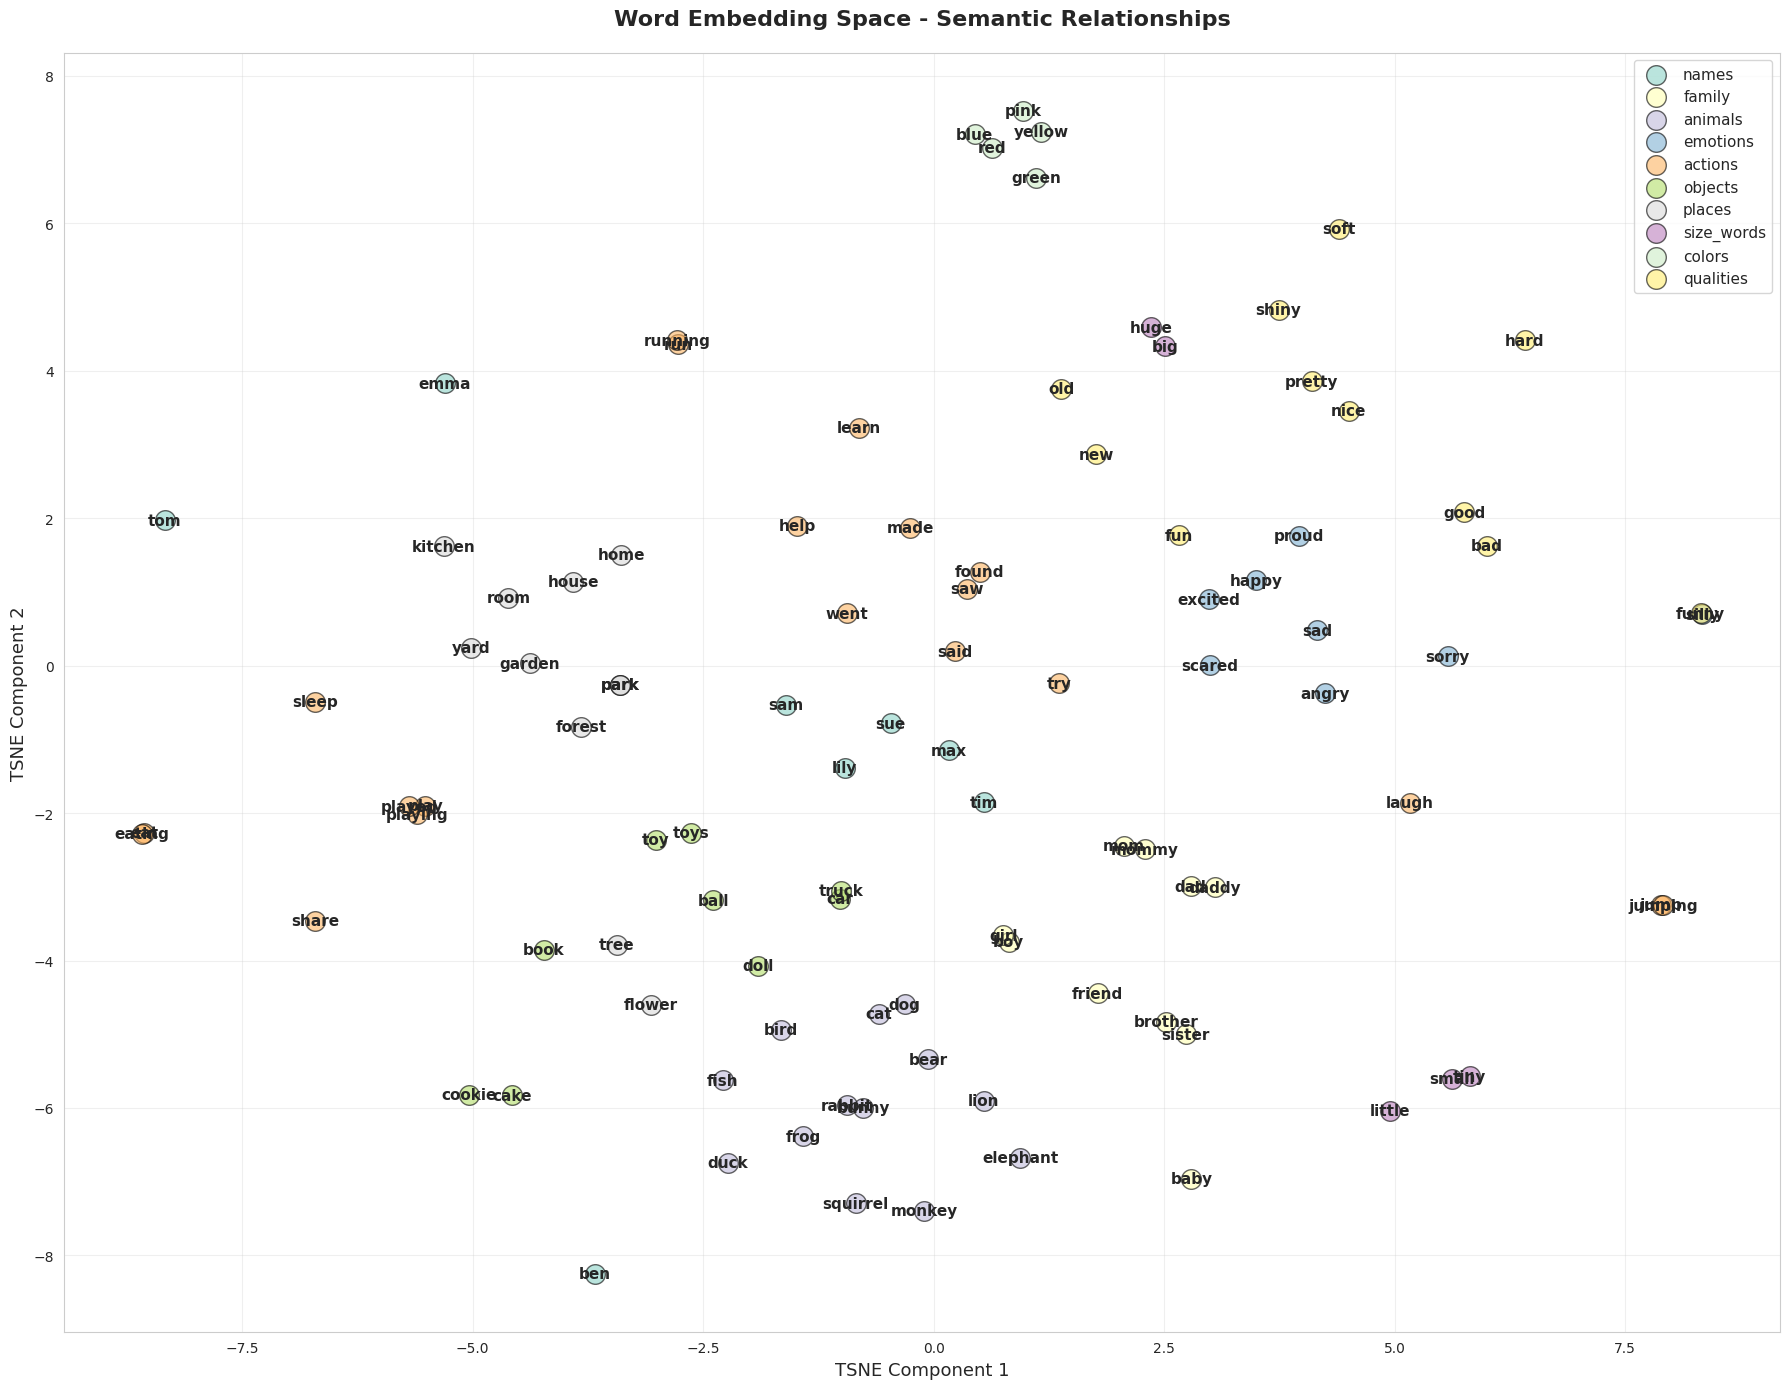

✓ Visualization complete! Semantically similar words should cluster together.


2. GENERATION DYNAMICS
GENERATION DYNAMICS VISUALIZATION
Prompt: 'Once upon a time there was a little girl named Lily who'
Tracking layer 2/2 (0-indexed) hidden states...

Generated: loved playing with yarn . She had many yarn s , but she didn ' t have any yarn to make herself fly . One day , she decided to order a p itch named T itch . Y um ! On the day of the park , Lily found a nice , soft spot to sit and sit . She put her hand on the p itch and waited for the T itch to come out . " Would

✓ Saved to: 2_generation_dynamics.png


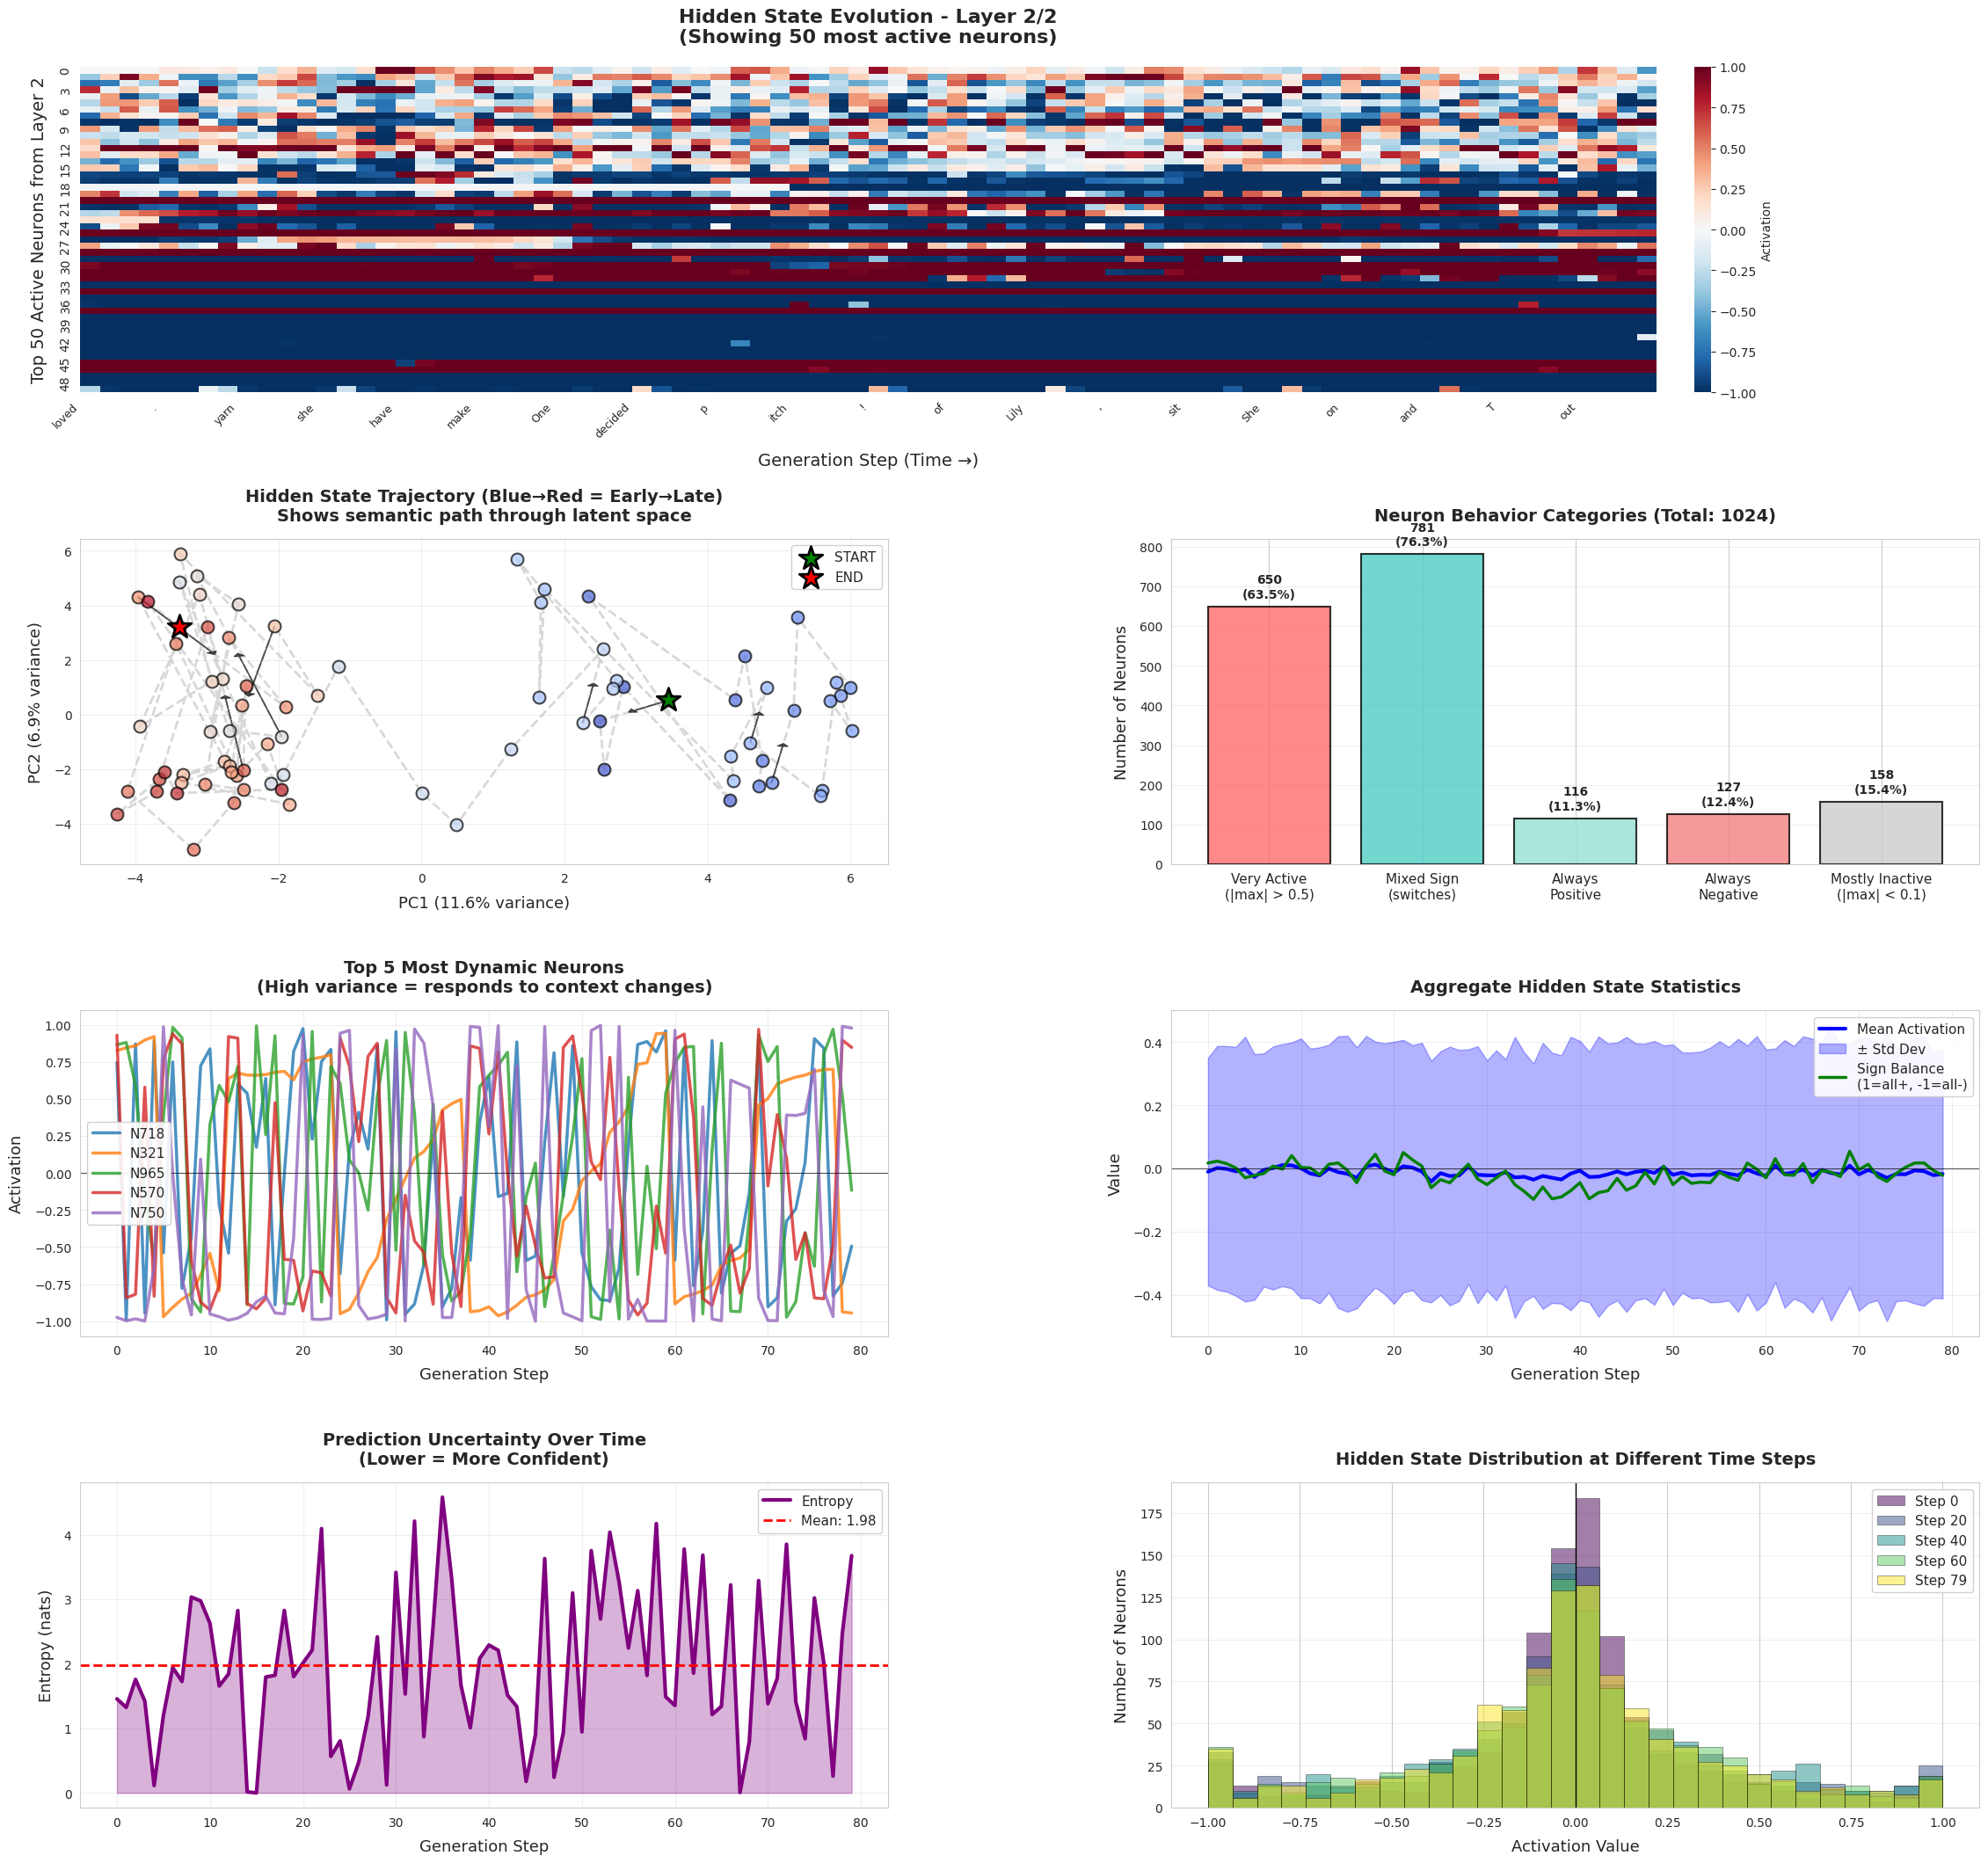


✓ Visualization complete!
  - Heatmap shows top 50 active neurons from layer 2
  - Trajectory shows semantic evolution (blue=early, red=late)
  - Dynamic neurons respond most to context changes
  - Low entropy = confident predictions


3. TOKEN IMPORTANCE ANALYSIS
TOKEN IMPORTANCE VISUALIZATION
Text: 'Once upon a time there was a little girl who loved to play with her toy'



Computing importance: 100%|██████████| 16/16 [00:00<00:00, 130.79it/s]


✓ Saved to: 3_token_importance.png


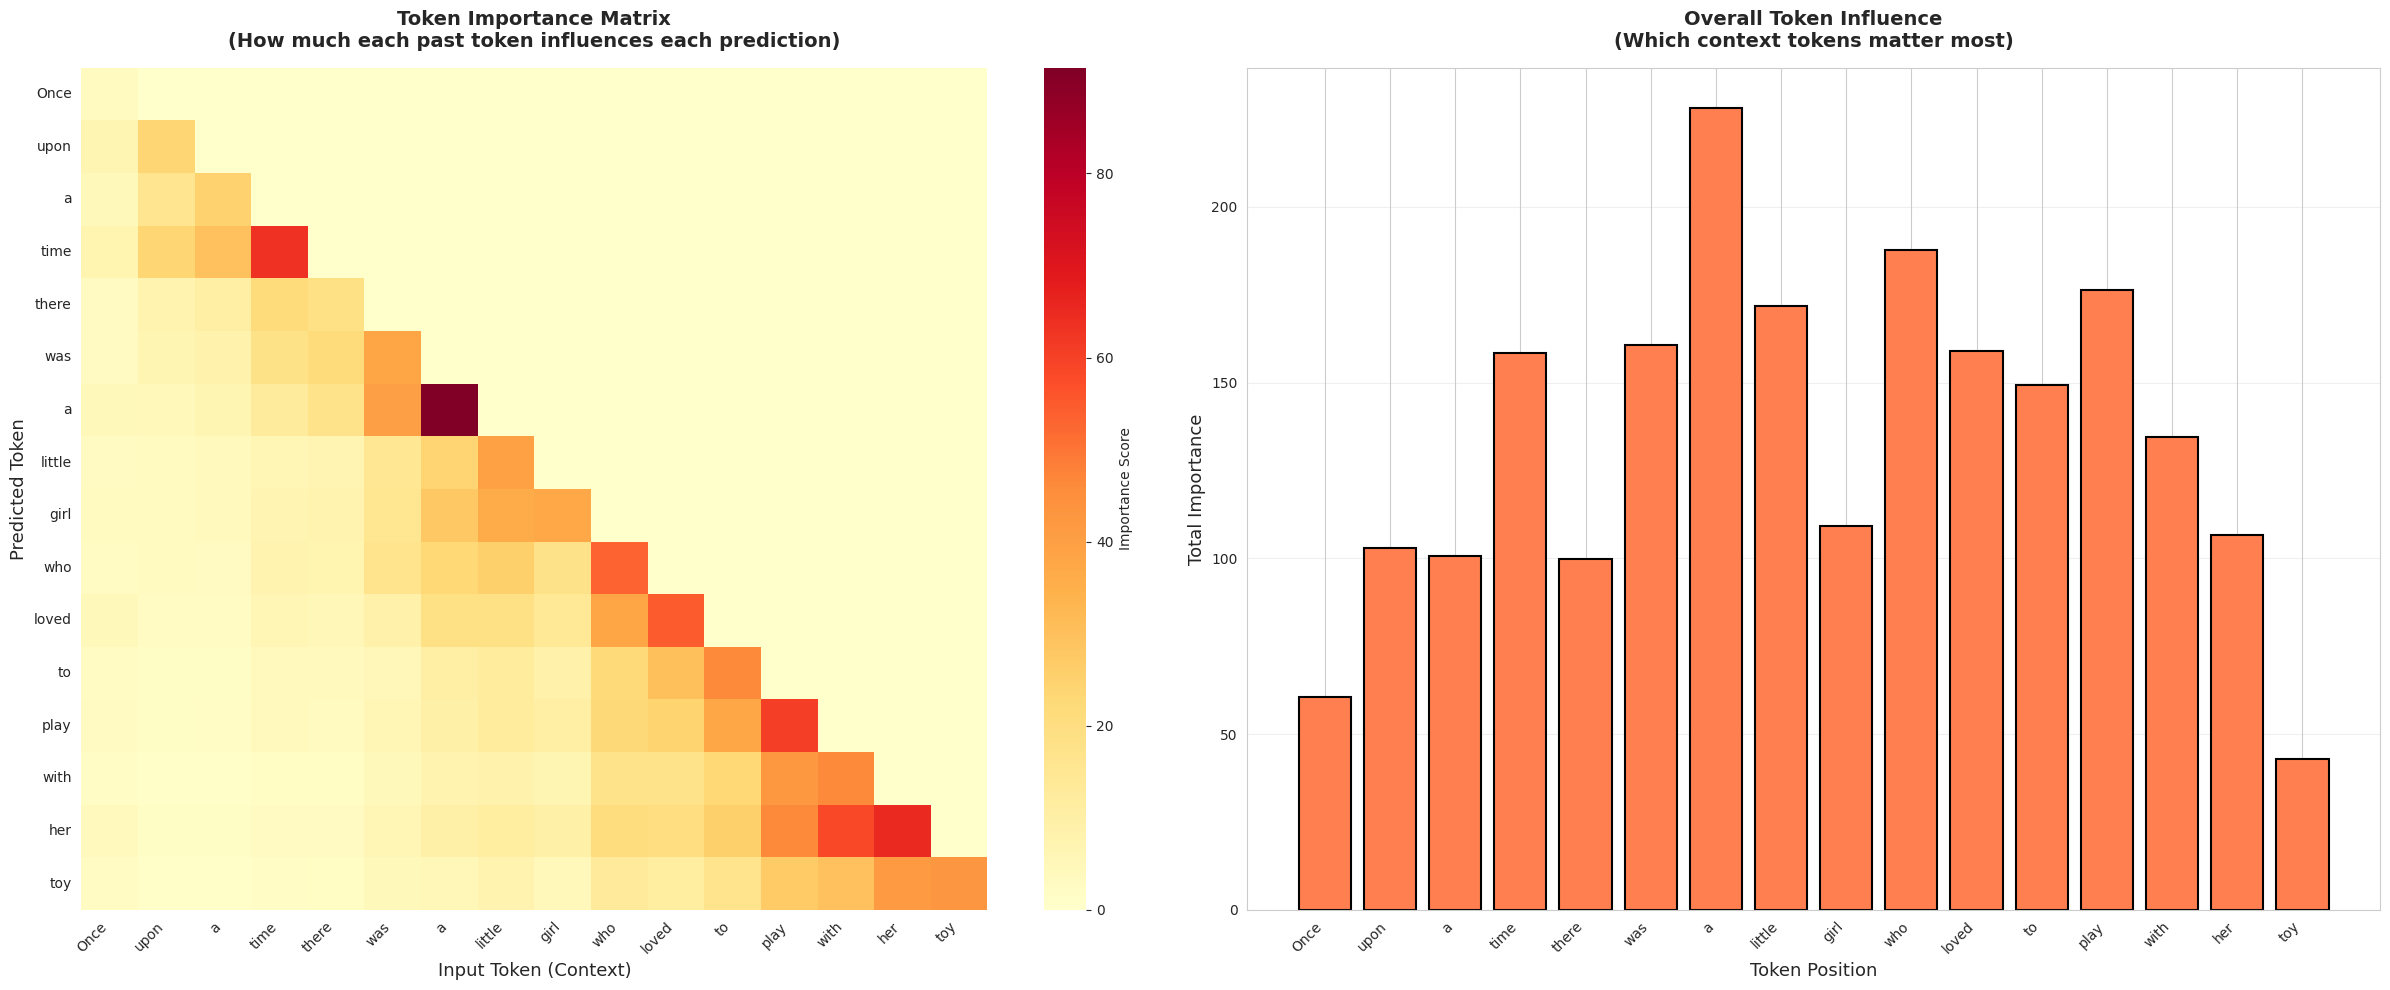

✓ Visualization complete!
  - Heatmap shows which past tokens influence each prediction
  - Bar chart shows which tokens are most influential overall


4. PREDICTION CONFIDENCE
PREDICTION CONFIDENCE VISUALIZATION
Analyzing: 'Once upon a time there was a'
Analyzing: 'Lily was very happy because'
Analyzing: 'The little girl wanted to'
Analyzing: 'Her mom said'
✓ Saved to: 4_prediction_confidence.png


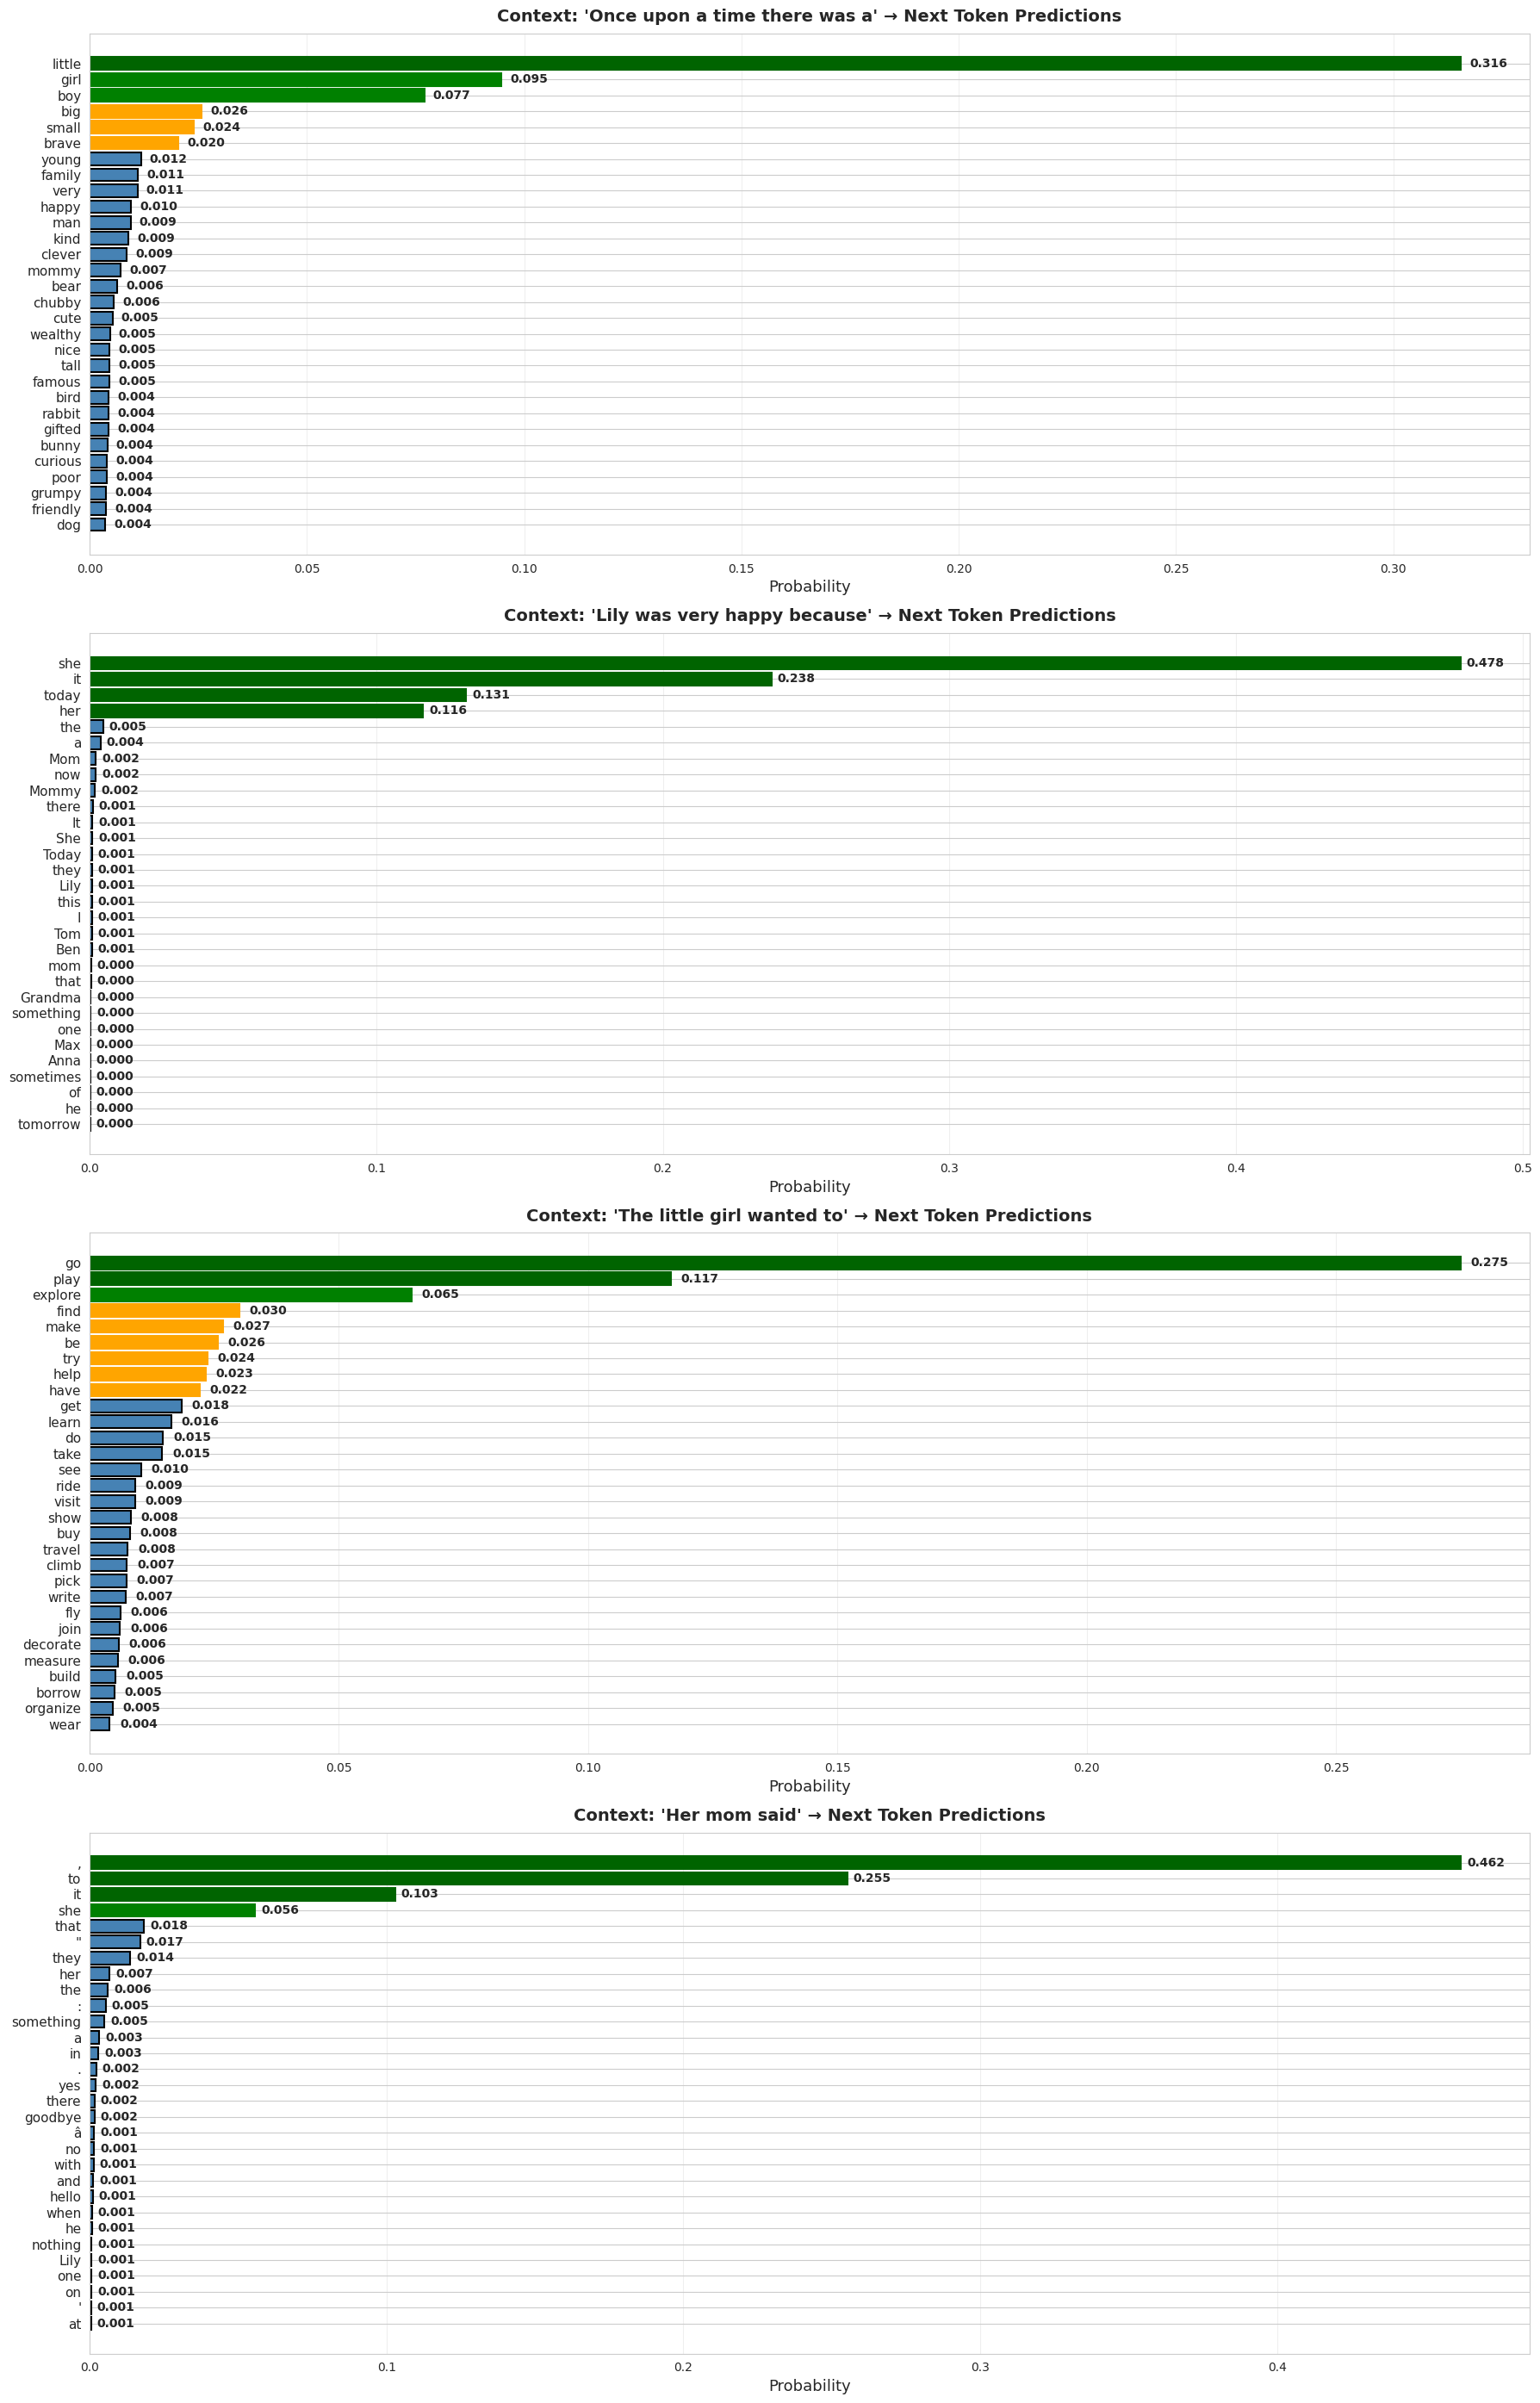

✓ Visualization complete!


5. GENERATION DIVERSITY
GENERATION DIVERSITY ANALYSIS
Prompt: 'One day, Lily went to the park and'
Generating 20 samples...



Generating: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


✓ Saved to: 5_generation_diversity.png


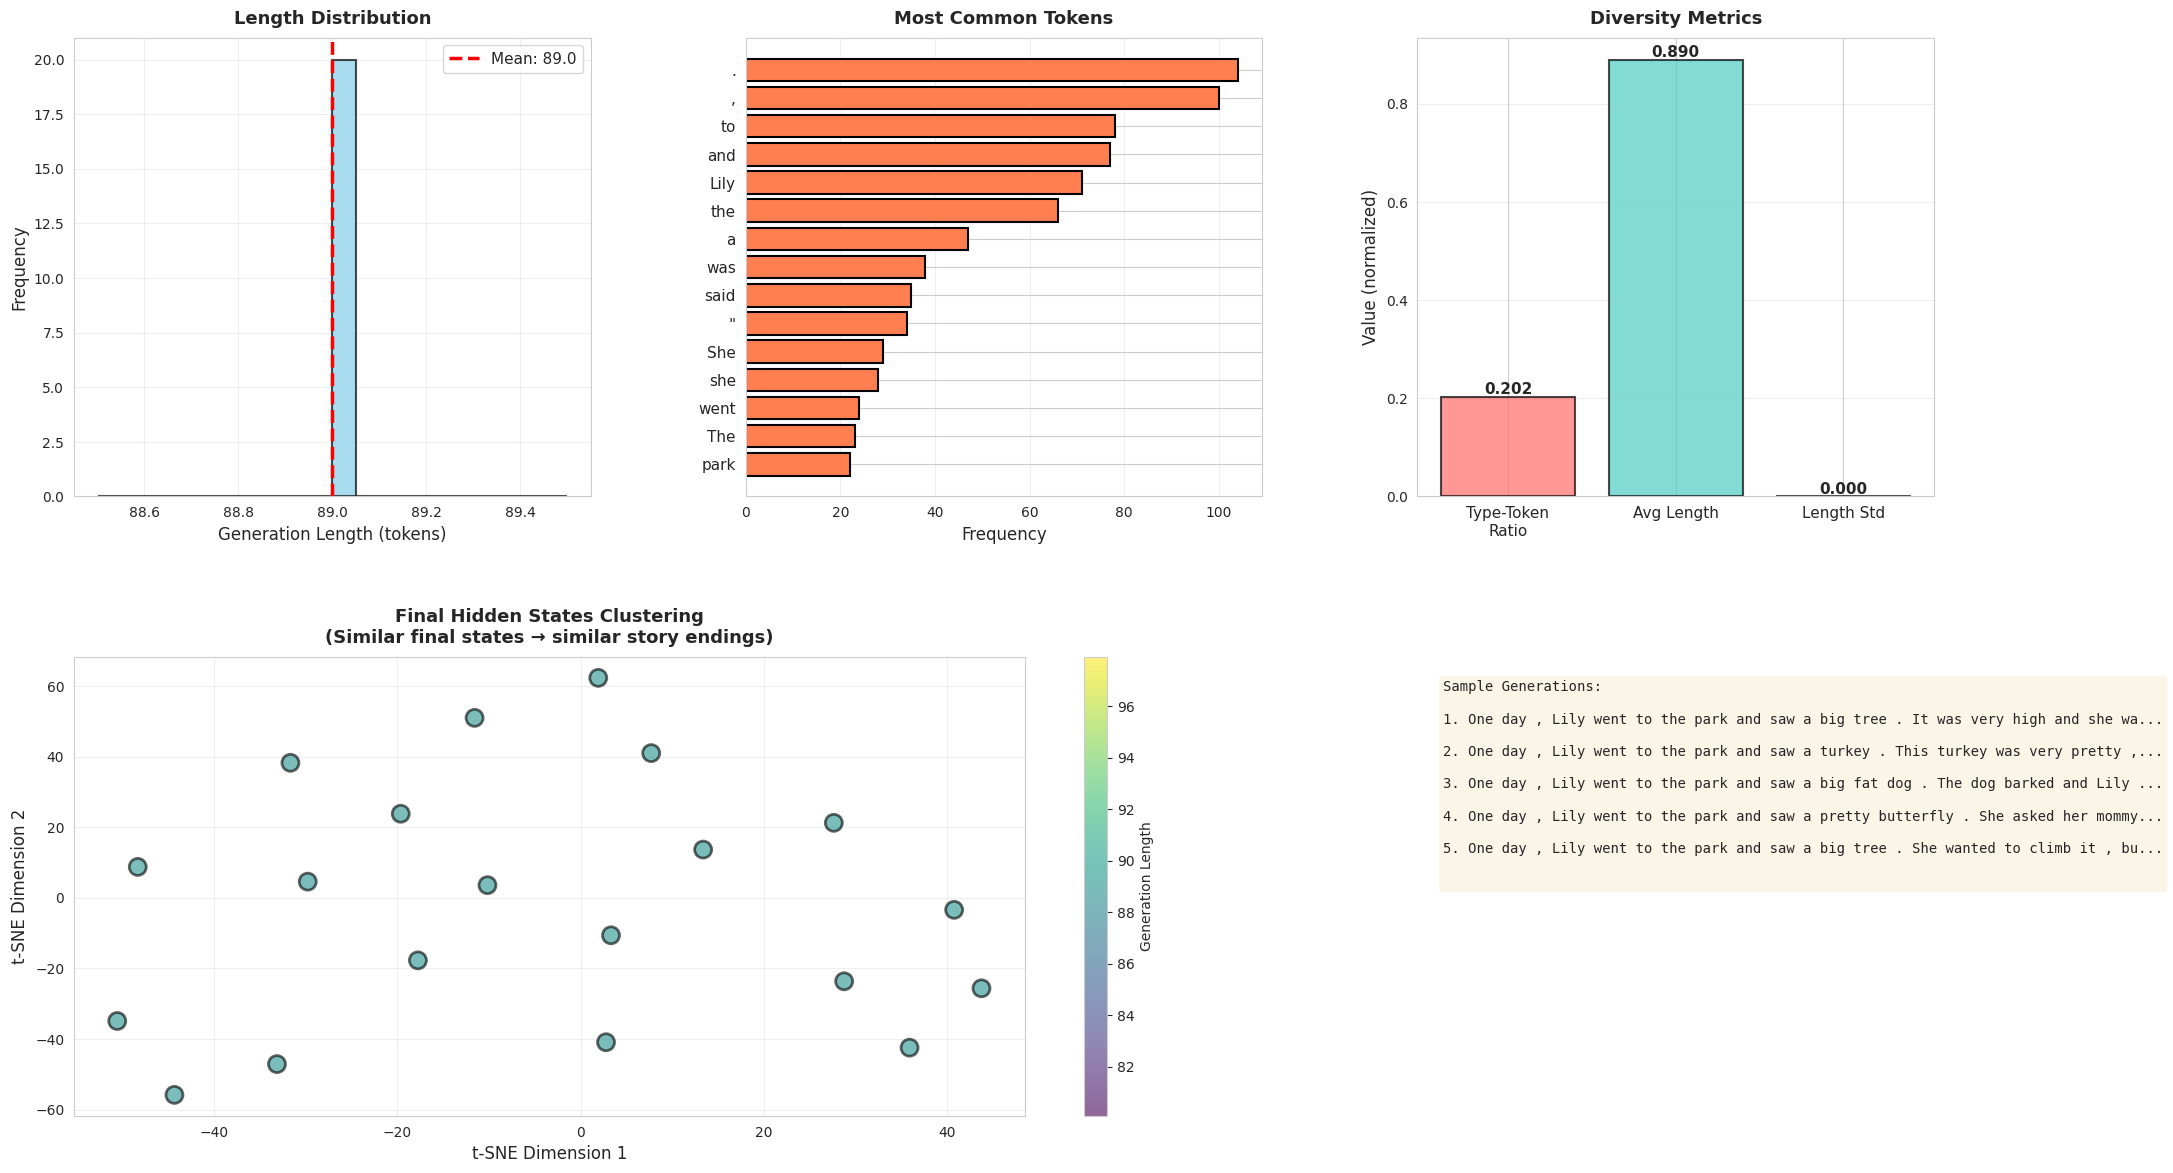


✓ Diversity Analysis Complete!
  Total tokens: 1,780
  Unique tokens: 360
  Type-Token Ratio: 0.2022
  Avg length: 89.0 ± 0.0 tokens


ANALYSIS COMPLETE!


In [19]:
"""
Visual Model Analysis for GRU Story Generator
Comprehensive visualizations to gain insights into model behavior
Saves high-quality PNG files for each visualization
"""

import torch
import torch.nn as nn
from tokenizers import Tokenizer
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# ============================================================================
# Visual Analyzer Class
# ============================================================================

class VisualModelAnalyzer:
    def __init__(self, model_path, tokenizer_path=None, device=None):
        """Initialize model analyzer with visualization capabilities"""
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.device = torch.device(device)
        print(f"Using device: {device}")
        
        # Load checkpoint
        print(f"Loading model from {model_path}...")
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Extract config from state dict
        state_dict = checkpoint['model_state']
        self.vocab_size = state_dict['embed.weight'].shape[0]
        self.embed_dim = state_dict['embed.weight'].shape[1]
        self.hidden_dim = state_dict['gru.weight_hh_l0'].shape[1]
        self.num_layers = sum(1 for k in state_dict.keys() if 'gru.weight_hh_l' in k)
        self.dropout = 0.3
        
        print(f"Model: vocab={self.vocab_size}, embed={self.embed_dim}, hidden={self.hidden_dim}, layers={self.num_layers}")
        
        # Load tokenizer
        if tokenizer_path is None:
            tokenizer_path = checkpoint.get('tokenizer_path', 'tokenizer.json')
            if not os.path.exists(tokenizer_path):
                model_dir = os.path.dirname(model_path)
                tokenizer_path = os.path.join(model_dir, 'tokenizer.json')
        
        print(f"Loading tokenizer from {tokenizer_path}...")
        self.tokenizer = Tokenizer.from_file(tokenizer_path)
        self.pad_id = self.tokenizer.token_to_id("[PAD]")
        self.bos_id = self.tokenizer.token_to_id("[BOS]")
        self.eos_id = self.tokenizer.token_to_id("[EOS]")
        
        # Initialize model
        self.model = GRUStoryLM(
            self.vocab_size, self.embed_dim, self.hidden_dim,
            self.num_layers, self.dropout
        ).to(self.device)
        
        self.model.load_state_dict(checkpoint['model_state'])
        self.model.eval()
        
        print(f"✓ Model loaded successfully!\n")
    
    # ========================================================================
    # 1. Embedding Space Visualization (t-SNE/PCA)
    # ========================================================================
    
    def visualize_embeddings(self, words=None, method='tsne', n_components=2):
        """
        Visualize word embeddings in 2D/3D space
        Shows semantic relationships learned by the model
        """
        print("="*60)
        print("VISUALIZING EMBEDDING SPACE")
        print("="*60)
        
        embeddings = self.model.embed.weight.detach().cpu().numpy()
        
        # Select interesting words to visualize - TinyStories specific
        if words is None:
            words = [
                # Characters
                'lily', 'tim', 'sue', 'ben', 'sam', 'max', 'emma', 'tom',
                'boy', 'girl', 'mom', 'dad', 'mommy', 'daddy', 'friend', 'baby', 'sister', 'brother',
                # Animals
                'cat', 'dog', 'bird', 'bunny', 'rabbit', 'fish', 'frog', 'duck',
                'lion', 'bear', 'elephant', 'monkey', 'squirrel',
                # Emotions
                'happy', 'sad', 'angry', 'scared', 'excited', 'sorry', 'proud', 'silly',
                # Actions
                'play', 'playing', 'played', 'run', 'running', 'jump', 'jumping',
                'eat', 'eating', 'sleep', 'laugh', 'said', 'went', 'saw', 'found',
                'help', 'share', 'learn', 'try', 'made',
                # Objects
                'toy', 'toys', 'ball', 'book', 'car', 'truck', 'doll',
                'house', 'tree', 'flower', 'park', 'garden', 'cake', 'cookie',
                # Places
                'home', 'park', 'yard', 'room', 'kitchen', 'forest',
                # Descriptors
                'big', 'small', 'little', 'tiny', 'huge',
                'red', 'blue', 'green', 'yellow', 'pink',
                'good', 'bad', 'nice', 'pretty', 'fun', 'funny',
                'old', 'new', 'shiny', 'soft', 'hard'
            ]
        
        # Get word embeddings and indices
        word_embeds = []
        valid_words = []
        
        for word in words:
            word_ids = self.tokenizer.encode(word).ids
            if word_ids:
                word_embeds.append(embeddings[word_ids[0]])
                valid_words.append(word)
        
        word_embeds = np.array(word_embeds)
        
        # Dimensionality reduction
        print(f"Reducing {word_embeds.shape[1]}D embeddings to {n_components}D using {method.upper()}...")
        
        if method == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42, perplexity=min(30, len(valid_words)-1))
        else:
            reducer = PCA(n_components=n_components)
        
        reduced = reducer.fit_transform(word_embeds)
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(18, 14))
        
        # Color by category - TinyStories specific
        categories = {
            'names': ['lily', 'tim', 'sue', 'ben', 'sam', 'max', 'emma', 'tom'],
            'family': ['boy', 'girl', 'mom', 'dad', 'mommy', 'daddy', 'sister', 'brother', 'baby', 'friend'],
            'animals': ['cat', 'dog', 'bird', 'bunny', 'rabbit', 'fish', 'frog', 'duck', 'lion', 'bear', 'elephant', 'monkey', 'squirrel'],
            'emotions': ['happy', 'sad', 'angry', 'scared', 'excited', 'sorry', 'proud', 'silly'],
            'actions': ['play', 'playing', 'played', 'run', 'running', 'jump', 'jumping', 'eat', 'eating', 'sleep', 'laugh', 'said', 'went', 'saw', 'found', 'help', 'share', 'learn', 'try', 'made'],
            'objects': ['toy', 'toys', 'ball', 'book', 'car', 'truck', 'doll', 'cake', 'cookie'],
            'places': ['home', 'house', 'park', 'yard', 'room', 'kitchen', 'forest', 'tree', 'flower', 'garden'],
            'size_words': ['big', 'small', 'little', 'tiny', 'huge'],
            'colors': ['red', 'blue', 'green', 'yellow', 'pink'],
            'qualities': ['good', 'bad', 'nice', 'pretty', 'fun', 'funny', 'old', 'new', 'shiny', 'soft', 'hard']
        }
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
        
        for idx, (cat_name, cat_words) in enumerate(categories.items()):
            cat_indices = [i for i, w in enumerate(valid_words) if w in cat_words]
            if cat_indices:
                ax.scatter(reduced[cat_indices, 0], reduced[cat_indices, 1],
                          c=[colors[idx]], label=cat_name, s=200, alpha=0.6, edgecolors='black')
        
        # Add word labels
        for i, word in enumerate(valid_words):
            ax.annotate(word, (reduced[i, 0], reduced[i, 1]),
                       fontsize=11, ha='center', va='center', weight='bold')
        
        ax.set_xlabel(f'{method.upper()} Component 1', fontsize=13)
        ax.set_ylabel(f'{method.upper()} Component 2', fontsize=13)
        ax.set_title('Word Embedding Space - Semantic Relationships', fontsize=16, weight='bold', pad=20)
        ax.legend(loc='best', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        save_path = '1_embedding_space.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")
        
        plt.show()
        
        print(f"✓ Visualization complete! Semantically similar words should cluster together.\n")
    
    # ========================================================================
    # 2. Hidden State Dynamics During Generation
    # ========================================================================
    
    def visualize_generation_dynamics(self, prompt, max_len=100, layer=-1):
        """
        Visualize how hidden states evolve during text generation
        Shows what the model is "thinking" as it generates
        
        Args:
            layer: Which GRU layer to visualize (-1 for last layer, 0 for first)
        """
        print("="*60)
        print("GENERATION DYNAMICS VISUALIZATION")
        print("="*60)
        print(f"Prompt: '{prompt}'")
        
        # Convert layer index
        if layer == -1:
            layer = self.num_layers - 1
        
        print(f"Tracking layer {layer}/{self.num_layers-1} (0-indexed) hidden states...\n")
        
        self.model.eval()
        
        # Generate with tracking
        tokens = [self.bos_id] + self.tokenizer.encode(prompt).ids
        generated_tokens = []
        hidden_states = []
        output_probs = []
        
        with torch.no_grad():
            for step in range(max_len):
                x = torch.tensor([tokens], device=self.device)
                
                # Forward pass with hidden state tracking
                embedded = self.model.embed(x)
                gru_output, hidden = self.model.gru(embedded)
                logits = self.model.proj(gru_output)
                
                # Store hidden state for specified layer
                h = hidden[layer].squeeze(1).cpu().numpy()[0]
                hidden_states.append(h)
                
                # Get probabilities for next token
                probs = torch.softmax(logits[0, -1, :], dim=0)
                output_probs.append(probs.cpu().numpy())
                
                # Sample next token
                next_token = torch.multinomial(probs, 1).item()
                
                if next_token == self.eos_id:
                    break
                
                tokens.append(next_token)
                generated_tokens.append(next_token)
        
        # Decode generated text
        generated_text = self.tokenizer.decode(generated_tokens)
        word_tokens = [self.tokenizer.decode([t]) for t in generated_tokens]
        
        print(f"Generated: {generated_text}\n")
        
        # Convert to arrays
        hidden_states = np.array(hidden_states)
        
        # Create comprehensive visualization with more vertical space
        fig = plt.figure(figsize=(24, 22))
        gs = fig.add_gridspec(4, 2, hspace=0.45, wspace=0.35, 
                             height_ratios=[1, 1, 1, 1])
        
        # 1. Hidden state evolution heatmap (top neurons only)
        ax1 = fig.add_subplot(gs[0, :])
        
        # Select top 50 most active neurons
        neuron_activity = np.abs(hidden_states).max(axis=0)
        top_neuron_indices = np.argsort(neuron_activity)[-50:]
        selected_hidden = hidden_states[:, top_neuron_indices]
        
        sns.heatmap(selected_hidden.T, cmap='RdBu_r', center=0, 
                    cbar_kws={'label': 'Activation', 'pad': 0.02}, ax=ax1, vmin=-1, vmax=1)
        ax1.set_xlabel('Generation Step (Time →)', fontsize=14, labelpad=10)
        ax1.set_ylabel(f'Top 50 Active Neurons from Layer {layer}', fontsize=14, labelpad=10)
        ax1.set_title(f'Hidden State Evolution - Layer {layer}/{self.num_layers-1}\n(Showing 50 most active neurons)', 
                     fontsize=16, weight='bold', pad=20)
        
        # Add word labels on x-axis (every few steps if too many)
        step_interval = max(1, len(word_tokens) // 20)
        tick_positions = range(0, len(word_tokens), step_interval)
        ax1.set_xticks(tick_positions)
        ax1.set_xticklabels([word_tokens[i] if i < len(word_tokens) else '' 
                            for i in tick_positions], rotation=45, ha='right', fontsize=9)
        
        # 2. PCA trajectory with clear progression markers
        ax2 = fig.add_subplot(gs[1, 0])
        if len(hidden_states) > 2:
            pca = PCA(n_components=2)
            hidden_pca = pca.fit_transform(hidden_states)
            
            # Draw trajectory line first
            ax2.plot(hidden_pca[:, 0], hidden_pca[:, 1], 'gray', alpha=0.3, linewidth=2, linestyle='--')
            
            # Color points by position in sequence (early=blue, late=red)
            colors_gradient = plt.cm.coolwarm(np.linspace(0, 1, len(hidden_pca)))
            
            for i in range(len(hidden_pca)):
                ax2.scatter(hidden_pca[i, 0], hidden_pca[i, 1], 
                          c=[colors_gradient[i]], s=100, alpha=0.7, 
                          edgecolors='black', linewidth=1.5, zorder=3)
            
            # Mark key points
            ax2.scatter(hidden_pca[0, 0], hidden_pca[0, 1], 
                       c='green', s=400, marker='*', edgecolors='black', 
                       linewidth=2, label='START', zorder=5)
            ax2.scatter(hidden_pca[-1, 0], hidden_pca[-1, 1], 
                       c='red', s=400, marker='*', edgecolors='black', 
                       linewidth=2, label='END', zorder=5)
            
            # Add arrows every N steps
            arrow_interval = max(1, len(hidden_pca) // 8)
            for i in range(0, len(hidden_pca)-1, arrow_interval):
                dx = hidden_pca[i+1, 0] - hidden_pca[i, 0]
                dy = hidden_pca[i+1, 1] - hidden_pca[i, 1]
                ax2.arrow(hidden_pca[i, 0], hidden_pca[i, 1], dx*0.5, dy*0.5,
                         head_width=0.15, head_length=0.1, fc='black', 
                         ec='black', alpha=0.6, zorder=2)
            
            ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=13, labelpad=8)
            ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=13, labelpad=8)
            ax2.set_title('Hidden State Trajectory (Blue→Red = Early→Late)\nShows semantic path through latent space', 
                         fontsize=14, weight='bold', pad=15)
            ax2.legend(fontsize=11, loc='best', framealpha=0.9)
            ax2.grid(True, alpha=0.3)
        
        # 3. Neuron activity categories
        ax3 = fig.add_subplot(gs[1, 1])
        
        # Find neurons with different behaviors
        neuron_means = hidden_states.mean(axis=0)
        neuron_stds = hidden_states.std(axis=0)
        neuron_maxabs = np.abs(hidden_states).max(axis=0)
        
        # Categorize neurons
        always_positive = np.sum((hidden_states > 0).all(axis=0))
        always_negative = np.sum((hidden_states < 0).all(axis=0))
        mixed_sign = np.sum((hidden_states > 0).any(axis=0) & (hidden_states < 0).any(axis=0))
        mostly_inactive = np.sum(neuron_maxabs < 0.1)
        very_active = np.sum(neuron_maxabs > 0.5)
        
        categories = {
            'Very Active\n(|max| > 0.5)': very_active,
            'Mixed Sign\n(switches)': mixed_sign,
            'Always\nPositive': always_positive,
            'Always\nNegative': always_negative,
            'Mostly Inactive\n(|max| < 0.1)': mostly_inactive,
        }
        
        colors_cat = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#CCCCCC']
        bars = ax3.bar(range(len(categories)), categories.values(), 
                      color=colors_cat, edgecolor='black', linewidth=1.5, alpha=0.8)
        ax3.set_xticks(range(len(categories)))
        ax3.set_xticklabels(categories.keys(), fontsize=11)
        ax3.set_ylabel('Number of Neurons', fontsize=13, labelpad=8)
        ax3.set_title(f'Neuron Behavior Categories (Total: {self.hidden_dim})', 
                     fontsize=14, weight='bold', pad=15)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add percentages with better positioning
        for bar, val in zip(bars, categories.values()):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 15,
                    f'{val}\n({val/self.hidden_dim*100:.1f}%)', 
                    ha='center', va='bottom', fontsize=10, weight='bold')
        
        # 4. Individual neuron traces (most interesting ones)
        ax4 = fig.add_subplot(gs[2, 0])
        
        # Find neurons with interesting patterns
        # - High variance (dynamic)
        dynamic_neurons = np.argsort(neuron_stds)[-5:]
        
        for i, neuron in enumerate(dynamic_neurons):
            ax4.plot(hidden_states[:, neuron], label=f'N{neuron}', 
                    alpha=0.8, linewidth=2.5)
        
        ax4.set_xlabel('Generation Step', fontsize=13, labelpad=8)
        ax4.set_ylabel('Activation', fontsize=13, labelpad=8)
        ax4.set_title('Top 5 Most Dynamic Neurons\n(High variance = responds to context changes)', 
                     fontsize=14, weight='bold', pad=15)
        ax4.legend(fontsize=11, loc='best', framealpha=0.9)
        ax4.grid(True, alpha=0.3)
        ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        
        # 5. Average activation patterns
        ax5 = fig.add_subplot(gs[2, 1])
        ax5.plot(hidden_states.mean(axis=1), label='Mean Activation', linewidth=3, color='blue')
        ax5.fill_between(range(len(hidden_states)), 
                        hidden_states.mean(axis=1) - hidden_states.std(axis=1),
                        hidden_states.mean(axis=1) + hidden_states.std(axis=1),
                        alpha=0.3, color='blue', label='± Std Dev')
        ax5.plot((hidden_states > 0).mean(axis=1) * 2 - 1, 
                label='Sign Balance\n(1=all+, -1=all-)', linewidth=2.5, color='green')
        
        ax5.set_xlabel('Generation Step', fontsize=13, labelpad=8)
        ax5.set_ylabel('Value', fontsize=13, labelpad=8)
        ax5.set_title('Aggregate Hidden State Statistics', fontsize=14, weight='bold', pad=15)
        ax5.legend(fontsize=11, framealpha=0.9)
        ax5.grid(True, alpha=0.3)
        ax5.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        
        # 6. Prediction entropy (model confidence)
        ax6 = fig.add_subplot(gs[3, 0])
        entropies = [-(p * np.log(p + 1e-10)).sum() for p in output_probs]
        
        ax6.plot(entropies, linewidth=3, color='purple', label='Entropy')
        ax6.axhline(np.mean(entropies), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(entropies):.2f}')
        
        # Shade high/low uncertainty regions
        ax6.fill_between(range(len(entropies)), entropies, 
                        alpha=0.3, color='purple')
        
        ax6.set_xlabel('Generation Step', fontsize=13, labelpad=8)
        ax6.set_ylabel('Entropy (nats)', fontsize=13, labelpad=8)
        ax6.set_title('Prediction Uncertainty Over Time\n(Lower = More Confident)', 
                     fontsize=14, weight='bold', pad=15)
        ax6.legend(fontsize=11, framealpha=0.9)
        ax6.grid(True, alpha=0.3)
        
        # 7. Activation distribution evolution
        ax7 = fig.add_subplot(gs[3, 1])
        
        # Sample a few time points
        time_points = [0, len(hidden_states)//4, len(hidden_states)//2, 
                      3*len(hidden_states)//4, len(hidden_states)-1]
        colors_time = plt.cm.viridis(np.linspace(0, 1, len(time_points)))
        
        for i, t in enumerate(time_points):
            if t < len(hidden_states):
                ax7.hist(hidden_states[t], bins=30, alpha=0.5, 
                        color=colors_time[i], label=f'Step {t}', 
                        edgecolor='black', linewidth=0.5)
        
        ax7.set_xlabel('Activation Value', fontsize=13, labelpad=8)
        ax7.set_ylabel('Number of Neurons', fontsize=13, labelpad=8)
        ax7.set_title('Hidden State Distribution at Different Time Steps', 
                     fontsize=14, weight='bold', pad=15)
        ax7.legend(fontsize=11, framealpha=0.9)
        ax7.grid(True, alpha=0.3, axis='y')
        ax7.axvline(x=0, color='k', linestyle='-', linewidth=1)
        
        # Adjust layout with more padding
        plt.subplots_adjust(top=0.96, bottom=0.06, left=0.06, right=0.96)
        
        # Save figure
        save_path = '2_generation_dynamics.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.3)
        print(f"✓ Saved to: {save_path}")
        
        plt.show()
        
        print(f"\n✓ Visualization complete!")
        print(f"  - Heatmap shows top 50 active neurons from layer {layer}")
        print(f"  - Trajectory shows semantic evolution (blue=early, red=late)")
        print(f"  - Dynamic neurons respond most to context changes")
        print(f"  - Low entropy = confident predictions\n")
    
    # ========================================================================
    # 3. Attention/Importance Visualization
    # ========================================================================
    
    def visualize_token_importance(self, text, max_tokens=30):
        """
        Visualize which past tokens influence each prediction
        Uses gradient-based attribution
        """
        print("="*60)
        print("TOKEN IMPORTANCE VISUALIZATION")
        print("="*60)
        print(f"Text: '{text}'\n")
        
        # Encode text
        tokens = [self.bos_id] + self.tokenizer.encode(text).ids[:max_tokens]
        token_words = [self.tokenizer.decode([t]) for t in tokens[1:]]
        
        self.model.train()  # Need gradients
        
        # Compute importance scores
        importance_matrix = np.zeros((len(tokens)-1, len(tokens)-1))
        
        for target_pos in tqdm(range(1, len(tokens)), desc="Computing importance"):
            x = torch.tensor([tokens[:target_pos]], device=self.device, requires_grad=False)
            
            # Create embeddings with gradient tracking
            embeddings = self.model.embed(x)
            embeddings = embeddings.clone().detach().requires_grad_(True)
            
            output, _ = self.model.gru(embeddings)
            logits = self.model.proj(output)
            
            # Get prediction at target position
            target_token = tokens[target_pos]
            target_logit = logits[0, -1, target_token]
            
            # Backprop
            target_logit.backward()
            
            # Gradient magnitude = importance
            if embeddings.grad is not None:
                grad_mag = embeddings.grad[0].abs().sum(dim=-1).cpu().numpy()
                importance_matrix[target_pos-1, :len(grad_mag)] = grad_mag
        
        self.model.eval()
        
        # Visualize importance matrix
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        
        # Heatmap
        sns.heatmap(importance_matrix, cmap='YlOrRd', ax=ax1,
                   xticklabels=token_words if len(token_words) <= 20 else False,
                   yticklabels=token_words if len(token_words) <= 20 else False,
                   cbar_kws={'label': 'Importance Score'})
        ax1.set_xlabel('Input Token (Context)', fontsize=13)
        ax1.set_ylabel('Predicted Token', fontsize=13)
        ax1.set_title('Token Importance Matrix\n(How much each past token influences each prediction)',
                     fontsize=14, weight='bold', pad=15)
        
        if len(token_words) <= 20:
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
            ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10)
        
        # Aggregate importance (which tokens are most influential overall)
        total_importance = importance_matrix.sum(axis=0)
        ax2.bar(range(len(total_importance)), total_importance, color='coral', edgecolor='black', linewidth=1.5)
        ax2.set_xlabel('Token Position', fontsize=13)
        ax2.set_ylabel('Total Importance', fontsize=13)
        ax2.set_title('Overall Token Influence\n(Which context tokens matter most)',
                     fontsize=14, weight='bold', pad=15)
        ax2.grid(True, alpha=0.3, axis='y')
        
        if len(token_words) <= 20:
            ax2.set_xticks(range(len(token_words)))
            ax2.set_xticklabels(token_words, rotation=45, ha='right', fontsize=10)
        
        plt.tight_layout()
        
        # Save figure
        save_path = '3_token_importance.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")
        
        plt.show()
        
        print(f"✓ Visualization complete!")
        print(f"  - Heatmap shows which past tokens influence each prediction")
        print(f"  - Bar chart shows which tokens are most influential overall\n")
    
    # ========================================================================
    # 4. Prediction Confidence Visualization
    # ========================================================================
    
    def visualize_prediction_confidence(self, contexts, temperature=1.0):
        """
        Visualize model's prediction confidence for different contexts
        """
        print("="*60)
        print("PREDICTION CONFIDENCE VISUALIZATION")
        print("="*60)
        
        self.model.eval()
        
        fig, axes = plt.subplots(len(contexts), 1, figsize=(18, 7*len(contexts)))
        if len(contexts) == 1:
            axes = [axes]
        
        for idx, context in enumerate(contexts):
            print(f"Analyzing: '{context}'")
            
            # Encode context
            tokens = [self.bos_id] + self.tokenizer.encode(context).ids
            x = torch.tensor([tokens], device=self.device)
            
            with torch.no_grad():
                logits, _ = self.model(x)
                logits = logits[0, -1, :] / temperature
                probs = torch.softmax(logits, dim=0)
            
            # Get top 30 predictions
            top_probs, top_indices = torch.topk(probs, 30)
            top_words = [self.tokenizer.decode([idx.item()]) for idx in top_indices]
            
            # Plot
            ax = axes[idx]
            bars = ax.barh(range(len(top_words)), top_probs.cpu().numpy(), color='steelblue', edgecolor='black', linewidth=1.5)
            
            # Color code by probability
            for i, (bar, prob) in enumerate(zip(bars, top_probs)):
                if prob > 0.1:
                    bar.set_color('darkgreen')
                elif prob > 0.05:
                    bar.set_color('green')
                elif prob > 0.02:
                    bar.set_color('orange')
            
            ax.set_yticks(range(len(top_words)))
            ax.set_yticklabels(top_words, fontsize=11)
            ax.set_xlabel('Probability', fontsize=13)
            ax.set_title(f"Context: '{context}' → Next Token Predictions", 
                        fontsize=14, weight='bold', pad=10)
            ax.grid(True, alpha=0.3, axis='x')
            ax.invert_yaxis()
            
            # Add probability values
            for i, (word, prob) in enumerate(zip(top_words, top_probs)):
                ax.text(prob.item() + 0.002, i, f'{prob.item():.3f}', 
                       va='center', fontsize=10, weight='bold')
        
        plt.tight_layout()
        
        # Save figure
        save_path = '4_prediction_confidence.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")
        
        plt.show()
        
        print(f"✓ Visualization complete!\n")
    
    # ========================================================================
    # 5. Generation Diversity Analysis
    # ========================================================================
    
    def visualize_generation_diversity(self, prompt, num_samples=20, max_len=100):
        """
        Visualize diversity across multiple generations from same prompt
        """
        print("="*60)
        print("GENERATION DIVERSITY ANALYSIS")
        print("="*60)
        print(f"Prompt: '{prompt}'")
        print(f"Generating {num_samples} samples...\n")
        
        # Generate multiple samples
        generations = []
        all_hidden_states = []
        
        for i in tqdm(range(num_samples), desc="Generating"):
            tokens = [self.bos_id] + self.tokenizer.encode(prompt).ids
            hidden_states = []
            
            with torch.no_grad():
                for _ in range(max_len):
                    x = torch.tensor([tokens], device=self.device)
                    embedded = self.model.embed(x)
                    output, hidden = self.model.gru(embedded)
                    logits = self.model.proj(output)
                    
                    # Store final hidden state
                    h = hidden[-1].squeeze(1).cpu().numpy()[0]
                    hidden_states.append(h)
                    
                    probs = torch.softmax(logits[0, -1, :], dim=0)
                    next_token = torch.multinomial(probs, 1).item()
                    
                    if next_token == self.eos_id:
                        break
                    tokens.append(next_token)
            
            text = self.tokenizer.decode(tokens[1:])
            generations.append(text)
            all_hidden_states.append(hidden_states[-1] if hidden_states else np.zeros(self.hidden_dim))
        
        # Compute diversity metrics
        all_tokens = []
        lengths = []
        for gen in generations:
            tok = self.tokenizer.encode(gen).ids
            all_tokens.extend(tok)
            lengths.append(len(tok))
        
        unique_tokens = len(set(all_tokens))
        total_tokens = len(all_tokens)
        
        # Create visualizations
        fig = plt.figure(figsize=(24, 14))
        gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)
        
        # 1. Length distribution
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.hist(lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7, linewidth=1.5)
        ax1.axvline(np.mean(lengths), color='red', linestyle='--', linewidth=2.5, label=f'Mean: {np.mean(lengths):.1f}')
        ax1.set_xlabel('Generation Length (tokens)', fontsize=12)
        ax1.set_ylabel('Frequency', fontsize=12)
        ax1.set_title('Length Distribution', fontsize=13, weight='bold', pad=10)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # 2. Token frequency
        ax2 = fig.add_subplot(gs[0, 1])
        token_counts = Counter(all_tokens)
        most_common = token_counts.most_common(15)
        words = [self.tokenizer.decode([t]) for t, _ in most_common]
        counts = [c for _, c in most_common]
        
        ax2.barh(range(len(words)), counts, color='coral', edgecolor='black', linewidth=1.5)
        ax2.set_yticks(range(len(words)))
        ax2.set_yticklabels(words, fontsize=11)
        ax2.set_xlabel('Frequency', fontsize=12)
        ax2.set_title('Most Common Tokens', fontsize=13, weight='bold', pad=10)
        ax2.invert_yaxis()
        ax2.grid(True, alpha=0.3, axis='x')
        
        # 3. Diversity metrics
        ax3 = fig.add_subplot(gs[0, 2])
        metrics = {
            'Type-Token\nRatio': unique_tokens / total_tokens,
            'Avg Length': np.mean(lengths) / 100,
            'Length Std': np.std(lengths) / 50,
        }
        
        colors_met = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        bars = ax3.bar(range(len(metrics)), metrics.values(), color=colors_met, edgecolor='black', alpha=0.7, linewidth=1.5)
        ax3.set_xticks(range(len(metrics)))
        ax3.set_xticklabels(metrics.keys(), fontsize=11)
        ax3.set_ylabel('Value (normalized)', fontsize=12)
        ax3.set_title('Diversity Metrics', fontsize=13, weight='bold', pad=10)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add values on bars
        for bar, val in zip(bars, metrics.values()):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=11, weight='bold')
        
        # 4. Hidden state clustering (t-SNE)
        ax4 = fig.add_subplot(gs[1, :2])
        if len(all_hidden_states) > 2:
            hidden_array = np.array(all_hidden_states)
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(10, len(hidden_array)-1))
            hidden_2d = tsne.fit_transform(hidden_array)
            
            scatter = ax4.scatter(hidden_2d[:, 0], hidden_2d[:, 1], 
                                 c=lengths, cmap='viridis', s=150, 
                                 alpha=0.6, edgecolors='black', linewidth=2)
            
            plt.colorbar(scatter, ax=ax4, label='Generation Length')
            ax4.set_xlabel('t-SNE Dimension 1', fontsize=12)
            ax4.set_ylabel('t-SNE Dimension 2', fontsize=12)
            ax4.set_title('Final Hidden States Clustering\n(Similar final states → similar story endings)', 
                         fontsize=13, weight='bold', pad=10)
            ax4.grid(True, alpha=0.3)
        
        # 5. Sample generations
        ax5 = fig.add_subplot(gs[1, 2])
        ax5.axis('off')
        sample_text = "Sample Generations:\n\n"
        for i in range(min(5, len(generations))):
            sample_text += f"{i+1}. {generations[i][:80]}...\n\n"
        
        ax5.text(0.05, 0.95, sample_text, transform=ax5.transAxes,
                fontsize=10, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.tight_layout()
        
        # Save figure
        save_path = '5_generation_diversity.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")
        
        plt.show()
        
        print(f"\n✓ Diversity Analysis Complete!")
        print(f"  Total tokens: {total_tokens:,}")
        print(f"  Unique tokens: {unique_tokens:,}")
        print(f"  Type-Token Ratio: {unique_tokens/total_tokens:.4f}")
        print(f"  Avg length: {np.mean(lengths):.1f} ± {np.std(lengths):.1f} tokens\n")

# ============================================================================
# Main Execution
# ============================================================================

# Initialize analyzer
model_path = '/kaggle/input/story-gru-lm/pytorch/default/1/gru_story_model.pt'
tokenizer_path = '/kaggle/input/story-gru-lm/pytorch/default/1/tokenizer.json'

analyzer = VisualModelAnalyzer(model_path, tokenizer_path)

# Run all visual analyses
print("\n" + "="*70)
print("1. EMBEDDING SPACE VISUALIZATION")
print("="*70)
analyzer.visualize_embeddings()

print("\n" + "="*70)
print("2. GENERATION DYNAMICS")
print("="*70)
analyzer.visualize_generation_dynamics("Once upon a time there was a little girl named Lily who", max_len=80)

print("\n" + "="*70)
print("3. TOKEN IMPORTANCE ANALYSIS")
print("="*70)
analyzer.visualize_token_importance("Once upon a time there was a little girl who loved to play with her toy")

print("\n" + "="*70)
print("4. PREDICTION CONFIDENCE")
print("="*70)
contexts = [
    "Once upon a time there was a",
    "Lily was very happy because",
    "The little girl wanted to",
    "Her mom said"
]
analyzer.visualize_prediction_confidence(contexts)

print("\n" + "="*70)
print("5. GENERATION DIVERSITY")
print("="*70)
analyzer.visualize_generation_diversity("One day, Lily went to the park and", num_samples=20, max_len=80)

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)

In [30]:
!jupyter nbconvert --to html /kaggle/input/temp-stuff/story-gru-lm.ipynb --output-dir=/kaggle/working/

[NbConvertApp] Converting notebook /kaggle/input/temp-stuff/story-gru-lm.ipynb to html
[NbConvertApp] Writing 3055248 bytes to /kaggle/working/story-gru-lm.html
